In [ ]:
# Social exp timeline

# Aeon3
#  2024-01-31 : 2024-02-03 - BAA-1104045 pre solo
#  2024-02-05 : 2024-02-08 - BAA-1104047 pre solo (dominant)
#  2024-02-09 : 2024-02-23 - BAA-1104045, BAA-1104047 social
#  2024-02-25 : 2024-02-28 - BAA-1104045 post solo
#  2024-02-28 : 2024-03-02 - BAA-1104047 post solo

# Aeon4
#  2024-01-31 : 2024-02-03 - BAA-1104048 pre solo (dominant)
#  2024-02-05 : 2024-02-08 - BAA-1104049 pre solo
#  2024-02-09 : 2024-02-23 - BAA-1104048, BAA-1104049 social
#  2024-02-25 : 2024-02-28 - BAA-1104048 post solo
#  2024-02-28 : 2024-03-02 - BAA-1104049 post solo

In [1]:
%load_ext autoreload
%autoreload 2
# %flow mode reactive

import itertools
import warnings
from importlib import reload
from pathlib import Path
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from dotmap import DotMap
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

import aeon
import datajoint as dj
from aeon.analysis.utils import visits, distancetravelled
from aeon.io import reader
from aeon.io.device import Device #register
from aeon.schema import core, foraging, social_02
from aeon.schema.schemas import exp02, social01, social02

## Load and Clean Data.

In [2]:
roots = [
    Path(f"Z:/aeon/data/raw/AEON3/social0.2"),
    Path(f"Z:/aeon/data/raw/AEON4/social0.2"),
]

In [3]:
"""Load data."""

blocks_df_2024_01_31 = pd.read_pickle(
    Path(r"Z:\aeon\code\scratchpad\jai\social02\social02_2024-01-31_2024-02-14.pkl")
)
blocks_df_2024_02_14 = pd.read_pickle(
    Path(r"Z:\aeon\code\scratchpad\jai\social02\social02_2024-02-14_2024-02-16.pkl")
)
blocks_df_2024_02_16 = pd.read_pickle(
    Path(r"Z:\aeon\code\scratchpad\jai\social02\social02_2024-02-16_2024-02-23.pkl")
)
blocks_df_2024_02_25 = pd.read_pickle(
    Path(r"Z:\aeon\code\scratchpad\jai\social02\social02_2024-02-25_2024-02-28.pkl")
)
blocks_df_2024_02_29 = pd.read_pickle(
    Path(r"Z:\aeon\code\scratchpad\jai\social02\social02_2024-02-29_2024-03-02.pkl")
)

skipped_blocks_2024_01_31 = np.load(
    Path(
        r"Z:\aeon\code\scratchpad\jai\social02\skipped_blocks_2024-01-31_2024-02-14.npy"
    )
)
skipped_blocks_2024_02_14 = np.load(
    Path(
        r"Z:\aeon\code\scratchpad\jai\social02\skipped_blocks_2024-02-14_2024-02-16.npy"
    )
)
skipped_blocks_2024_02_16 = np.load(
    Path(
        r"Z:\aeon\code\scratchpad\jai\social02\skipped_blocks_2024-02-16_2024-02-23.npy"
    )
)
skipped_blocks_2024_02_25 = np.load(
    Path(
        r"Z:\aeon\code\scratchpad\jai\social02\skipped_blocks_2024-02-25_2024-02-28.npy"
    )
)
skipped_blocks_2024_02_29 = np.load(
    Path(
        r"Z:\aeon\code\scratchpad\jai\social02\skipped_blocks_2024-02-29_2024-03-02.npy"
    )
)

In [4]:
"""Clean data."""

# Concatenate loaded data
blocks_df = pd.concat(
    [
        blocks_df_2024_01_31,
        blocks_df_2024_02_14,
        blocks_df_2024_02_16,
        blocks_df_2024_02_25,
        blocks_df_2024_02_29,
    ]
)
skipped_blocks = np.concatenate(
    [
        skipped_blocks_2024_01_31,
        skipped_blocks_2024_02_14,
        skipped_blocks_2024_02_16,
        skipped_blocks_2024_02_25,
        skipped_blocks_2024_02_29,
    ]
)
# Clean indices
blocks_df.reset_index(inplace=True, drop=True)
blocks_df_cp = blocks_df.drop(columns=["cum_wheel_dist"])
# Remove skipped blocks (blocks with few pellets)
good_blocks_df = blocks_df[~skipped_blocks]
# Further remove blocks with fewer than 5 pellets
good_blocks_df = good_blocks_df[
    good_blocks_df["pellet_info"].apply(len) > 5
].reset_index(drop=True)
# Make paths consistent with my ceph network map
good_blocks_df["root"] = good_blocks_df["root"].apply(
    lambda path: Path(str(path).replace("S:", "Z:"))
)
good_blocks_df["sleap_model_dir"] = good_blocks_df["sleap_model_dir"].apply(
    lambda path: Path(str(path).replace("S:", "Z:"))
)
# Round timestamps to nearest ms
good_blocks_df["start"] = good_blocks_df["start"].apply(lambda x: x.round("ms"))
good_blocks_df["end"] = good_blocks_df["end"].apply(lambda x: x.round("ms"))
good_blocks_df["block_duration"].apply(lambda x: x.round("ms"))
# Create df we can iterate through (pandas doesn't like format of "cum_wheel_dist" col for some reason)
good_blocks_df_cp = good_blocks_df.drop(columns=["cum_wheel_dist"])

In [5]:
"""See percentage of 'good' blocks (> 5 pellets)."""

pct_blocks_foraging = len(good_blocks_df_cp) / len(blocks_df)
print(f"{len(blocks_df)=}\n{len(good_blocks_df)=}\n{pct_blocks_foraging=:.3f}")

display(good_blocks_df_cp)

len(blocks_df)=645
len(good_blocks_df)=429
pct_blocks_foraging=0.665


,root,sleap_model_dir,start,end,block_duration,subjects,patch_info,pellet_info
0,Z:\aeon\data\raw\AEON4\social0.2,Z:\aeon\data\processed\test-node1\4350621\2024...,2024-01-31 12:59:06.006,2024-01-31 14:58:11.046,0 days 01:59:05.039999962,[BAA-1104048],mean offset Patch1 100.0 75.0 Patc...,time patch thr...
1,Z:\aeon\data\raw\AEON3\social0.2,Z:\aeon\data\processed\test-node1\4310907\2024...,2024-01-31 12:59:14.002,2024-01-31 14:45:59.000,0 days 01:46:44.998015881,[BAA-1104045],mean offset Patch1 100.0 75.0 Patc...,time patch th...
2,Z:\aeon\data\raw\AEON3\social0.2,Z:\aeon\data\processed\test-node1\4310907\2024...,2024-01-31 14:45:55.000,2024-01-31 16:18:11.002,0 days 01:32:16.001984119,[BAA-1104045],mean offset Patch1 100.0 75.0 Patc...,time patch thr...
3,Z:\aeon\data\raw\AEON4\social0.2,Z:\aeon\data\processed\test-node1\4350621\2024...,2024-01-31 14:58:07.046,2024-01-31 17:49:26.000,0 days 02:51:18.954016209,[BAA-1104048],mean offset Patch1 100.0 75.0 Patc...,time patch thr...
4,Z:\aeon\data\raw\AEON3\social0.2,Z:\aeon\data\processed\test-node1\4310907\2024...,2024-01-31 16:18:07.002,2024-01-31 17:56:23.000,0 days 01:38:15.998015881,[BAA-1104045],mean offset Patch1 500.0 75.0 Patc...,time patch th...
...,...,...,...,...,...,...,...,...
424,Z:\aeon\data\raw\AEON4\social0.2,Z:\aeon\data\processed\test-node1\4350621\2024...,2024-03-02 10:08:45.002,2024-03-02 11:43:28.006,0 days 01:34:43.003999710,[BAA-1104049],mean offset Patch1 100.0 75.0 Patc...,time patch thr...
425,Z:\aeon\data\raw\AEON3\social0.2,Z:\aeon\data\processed\test-node1\4310907\2024...,2024-03-02 10:57:26.002,2024-03-02 12:09:43.002,0 days 01:12:17,[BAA-1104047],mean offset Patch1 300.0 75.0 Patc...,time patch th...
426,Z:\aeon\data\raw\AEON4\social0.2,Z:\aeon\data\processed\test-node1\4350621\2024...,2024-03-02 11:43:24.006,2024-03-02 12:44:52.000,0 days 01:01:27.994016171,[BAA-1104049],mean offset Patch1 500.0 75.0 Patc...,time patch th...
427,Z:\aeon\data\raw\AEON3\social0.2,Z:\aeon\data\processed\test-node1\4310907\2024...,2024-03-02 12:09:39.002,2024-03-02 14:14:09.006,0 days 02:04:30.003999710,[BAA-1104047],mean offset Patch1 100.0 75.0 Patc...,time patch thr...


In [25]:
"""View a particular block."""

b_i = 0
block = good_blocks_df_cp.iloc[b_i]
print(block)

# Example for getting cum_wheel_dist
cum_wheel_dist = good_blocks_df["cum_wheel_dist"].iloc[b_i]  # have to use `iloc`

root                                Z:\aeon\data\raw\AEON4\social0.2
sleap_model_dir    Z:\aeon\data\processed\test-node1\4350621\2024...
start                                     2024-01-31 12:59:06.006000
end                                       2024-01-31 14:58:11.046000
block_duration                             0 days 01:59:05.039999962
subjects                                               [BAA-1104048]
patch_info                  mean offset
Patch1  100.0   75.0
Patc...
pellet_info                                    time   patch   thr...
Name: 0, dtype: object


In [ ]:
b = [
    "BAA-1104048" in subjects and (len(np.unique(patch_info["mean"])) > 2)
    for subjects, patch_info in zip(good_blocks_df_cp["subjects"].values, good_blocks_df_cp["patch_info"])
]
good_blocks_df_cp[b].iloc[0:30].reset_index()

In [6]:
"""Standardize subject colors, patch colors, and markers."""

subject_colors = plotly.colors.qualitative.Plotly
subject_colors_dict = {
    "BAA-1104045": subject_colors[0],
    "BAA-1104047": subject_colors[1],
    "BAA-1104048": subject_colors[2],
    "BAA-1104049": subject_colors[3],
}
patch_colors = plotly.colors.qualitative.Pastel2
patch_markers = [
    "hourglass",
    "bowtie",
    "square",
    "circle",
    "diamond",
    "cross",
    "x",
    "triangle",
    "star",
]

In [7]:
social_start = pd.Timestamp("2024-02-09")
social_end = pd.Timestamp("2024-02-23")

In [172]:
aeon3_metadata = aeon.load(roots[0], reader.Metadata(), start=pd.Timestamp("2024-01-31"), end=pd.Timestamp("2024-02-02"))
aeon4_metadata = aeon.load(roots[1], reader.Metadata(), start=pd.Timestamp("2024-01-31"), end=pd.Timestamp("2024-02-02"))

## Plot Social Distance Overview.

In [8]:
# Change model root path to my network mapped ceph path

social02.CameraTop.Pose._model_root = Path(r"Z:\aeon\data\processed")

In [48]:
# Function to see if in poly (in nest in particular)

#aeon3_metadata.metadata.iloc[0].ActiveRegion.NestRegion.ArrayOfPoint
aeon3_nest_bounds = ((1231, 485), (1231, 591), (1323, 591), (1323, 485))
aeon4_nest_bounds = ((1183, 517), (1183, 623), (1275, 623), (1275, 517))

aeon3_nest_bounds_polygon = Polygon(aeon3_nest_bounds)
aeon4_nest_bounds_polygon = Polygon(aeon4_nest_bounds)

def is_point_inside_polygon(point, polygon):
    return polygon.contains(Point(point))

In [68]:
# Get position for each individual animal for first day of solo
# Sample 100k points from each of these
# Create "synthetic" distribution of euclidean distances away from each other

# baa45_solo_pos = aeon.load(
#     roots[0],
#     social02.CameraTop.Pose,
#     pd.Timestamp("2024-02-01 00:00:00"),
#     pd.Timestamp("2024-02-02 00:00:00"),
# )
baa45_solo_pos["in_nest"] = baa45_solo_pos.apply(
    lambda row: is_point_inside_polygon((row["x"], row["y"]), aeon3_nest_bounds_polygon), axis=1
)
baa45_solo_pos = baa45_solo_pos[~baa45_solo_pos["in_nest"]]
# baa47_solo_pos = aeon.load(
#     roots[0],
#     social02.CameraTop.Pose,
#     pd.Timestamp("2024-02-06 00:00:00"),
#     pd.Timestamp("2024-02-07 00:00:00"),
# )
baa47_solo_pos["in_nest"] = baa47_solo_pos.apply(
    lambda row: is_point_inside_polygon((row["x"], row["y"]), aeon3_nest_bounds_polygon), axis=1
)
baa47_solo_pos = baa47_solo_pos[~baa47_solo_pos["in_nest"]]

# baa48_solo_pos = aeon.load(
#     roots[1],
#     social02.CameraTop.Pose,
#     pd.Timestamp("2024-02-01 00:00:00"),
#     pd.Timestamp("2024-02-02 00:00:00"),
# )
baa48_solo_pos["in_nest"] = baa48_solo_pos.apply(
    lambda row: is_point_inside_polygon((row["x"], row["y"]), aeon4_nest_bounds_polygon), axis=1
)
baa48_solo_pos = baa48_solo_pos[~baa48_solo_pos["in_nest"]]
# baa49_solo_pos = aeon.load(
#     roots[1],
#     social02.CameraTop.Pose,
#     pd.Timestamp("2024-02-06 00:00:00"),
#     pd.Timestamp("2024-02-07 00:00:00"),
# )
baa49_solo_pos["in_nest"] = baa49_solo_pos.apply(
    lambda row: is_point_inside_polygon((row["x"], row["y"]), aeon4_nest_bounds_polygon), axis=1
)
baa49_solo_pos = baa49_solo_pos[~baa49_solo_pos["in_nest"]]

# baa45_47_joint_pos = aeon.load(
#     roots[0],
#     social02.CameraTop.Pose,
#     pd.Timestamp("2024-02-15 00:00:00"),
#     pd.Timestamp("2024-02-16 00:00:00"),
# )
baa45_47_joint_pos["in_nest"] = baa45_47_joint_pos.apply(
    lambda row: is_point_inside_polygon((row["x"], row["y"]), aeon3_nest_bounds_polygon), axis=1
)
baa45_47_joint_pos = baa45_47_joint_pos[~baa45_47_joint_pos["in_nest"]]
# baa48_49_joint_pos = aeon.load(
#     roots[1],
#     social02.CameraTop.Pose,
#     pd.Timestamp("2024-02-15 00:00:00"),
#     pd.Timestamp("2024-02-16 00:00:00"),
# )
baa48_49_joint_pos["in_nest"] = baa48_49_joint_pos.apply(
    lambda row: is_point_inside_polygon((row["x"], row["y"]), aeon4_nest_bounds_polygon), axis=1
)
baa48_49_joint_pos = baa48_49_joint_pos[~baa48_49_joint_pos["in_nest"]]

In [70]:
baa45_from_joint = baa45_47_joint_pos[baa45_47_joint_pos["class"] == 0.0].sample(100000)
baa47_from_joint = baa45_47_joint_pos[baa45_47_joint_pos["class"] == 1.0].sample(100000)
distances2_45_47 = np.sqrt(
    ((baa45_from_joint["x"].values - baa47_from_joint["x"].values) ** 2)
    + ((baa45_from_joint["y"].values - baa47_from_joint["y"].values) ** 2)
)

baa48_from_joint = baa48_49_joint_pos[baa48_49_joint_pos["class"] == 0.0].sample(100000)
baa49_from_joint = baa48_49_joint_pos[baa48_49_joint_pos["class"] == 1.0].sample(100000)
distances2_48_49 = np.sqrt(
    ((baa48_from_joint["x"].values - baa49_from_joint["x"].values) ** 2)
    + ((baa48_from_joint["y"].values - baa49_from_joint["y"].values) ** 2)
)

sampled_df1 = baa48_solo_pos.sample(n=100000, random_state=1)
sampled_df2 = baa49_solo_pos.sample(n=100000, random_state=2)
distances0_48_49 = np.sqrt(
    ((sampled_df1["x"].values - sampled_df2["x"].values) ** 2)
    + ((sampled_df1["y"].values - sampled_df2["y"].values) ** 2)
)

sampled_df1 = baa45_solo_pos.sample(n=100000, random_state=1)
sampled_df2 = baa47_solo_pos.sample(n=100000, random_state=2)
distances0_45_47 = np.sqrt(
    ((sampled_df1["x"].values - sampled_df2["x"].values) ** 2)
    + ((sampled_df1["y"].values - sampled_df2["y"].values) ** 2)
)

In [52]:
px2cm = 7.2

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(distances0_45_47 / px2cm, kde=True, bins=1000, ax=ax, stat="probability")
sns.histplot(distances2_45_47 / px2cm, kde=True, bins=1000, ax=ax, stat="probability")
ax.set_title("Distances between subjects 45-47 (excluding nest)", fontsize=21)
ax.set_xlabel("Distance (cm)", fontsize=19)
ax.set_ylabel("Probability", fontsize=19)
ax.legend(["Synthetic", "True"], fontsize=17)
ax.set_ylim((0, 0.012))
ax.set_xlim((0, 160))
ax.tick_params(axis="both", which="major", labelsize=17)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(distances0_48_49 / px2cm, kde=True, bins=1000, ax=ax, stat="probability")
sns.histplot(distances2_48_49 / px2cm, kde=True, bins=1000, ax=ax, stat="probability")
ax.set_title("Distances between subjects 48-49 (excluding nest)", fontsize=21)
ax.set_xlabel("Distance (cm)", fontsize=19)
ax.set_ylabel("Probability", fontsize=19)
ax.legend(["Synthetic", "True"], fontsize=17)
ax.set_ylim((0, 0.012))
ax.set_xlim((0, 160))
ax.tick_params(axis="both", which="major", labelsize=17)

## Plot Foraging Times.

In [101]:
all_subjects = list(set(itertools.chain.from_iterable(good_blocks_df_cp["subjects"].values)))
foraging_times = pd.DataFrame(columns=["start", "subject"])

def contains_id(subject, pellet_info):
    return subject in pellet_info["id"].values

for subject in all_subjects:
    mask = good_blocks_df_cp["pellet_info"].apply(lambda x: contains_id(subject, x))
    start_times = good_blocks_df_cp[mask]["start"]
    foraging_times = pd.concat(
        [foraging_times, pd.DataFrame({"start": start_times, "subject": subject})]
    )
foraging_times["hour"] = foraging_times["start"].dt.hour

C:\Users\jai\AppData\Local\Temp\ipykernel_4968\83771515.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  foraging_times = pd.concat(


In [102]:
foraging_times

,start,subject,hour
49,2024-02-05 17:32:55.004,BAA-1104047,17
52,2024-02-06 06:24:44.018,BAA-1104047,6
55,2024-02-06 08:44:54.002,BAA-1104047,8
56,2024-02-06 10:12:10.002,BAA-1104047,10
58,2024-02-06 11:52:48.006,BAA-1104047,11
...,...,...,...
379,2024-02-28 05:41:49.006,BAA-1104048,5
381,2024-02-28 07:09:41.002,BAA-1104048,7
384,2024-02-28 09:29:03.000,BAA-1104048,9
385,2024-02-28 11:23:07.002,BAA-1104048,11


In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=foraging_times, 
    x="hour", 
    hue="subject", 
    palette=subject_colors_dict, 
    discrete=True, 
    bins=24, 
    multiple="stack"
)
# Make x-ticks by 2, and y-ticks by 5
ax.set_xticks(range(0, 24, 2)), ax.set_yticks(range(0, 51, 5))  # type: ignore
ax.set_title("Foraging Times")

In [100]:
block.pellet_info

,time,patch,threshold,id
0,2024-03-02 13:02:35.452000141,Patch1,195.082135,BAA-1104049
1,2024-03-02 13:02:55.261983870,Patch1,136.644876,BAA-1104049
2,2024-03-02 13:03:09.323999882,Patch1,139.419400,BAA-1104049
3,2024-03-02 13:03:22.671999931,Patch1,178.313691,BAA-1104049
4,2024-03-02 13:03:39.917984009,Patch1,273.823791,BAA-1104049
5,2024-03-02 13:04:04.171999931,Patch1,187.578029,BAA-1104049
6,2024-03-02 13:04:22.584000111,Patch1,204.851004,BAA-1104049
7,2024-03-02 13:04:43.373983860,Patch1,233.117978,BAA-1104049
8,2024-03-02 13:33:59.313983917,Patch1,116.926161,BAA-1104049
9,2024-03-02 13:34:12.607999802,Patch1,87.973376,BAA-1104049


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

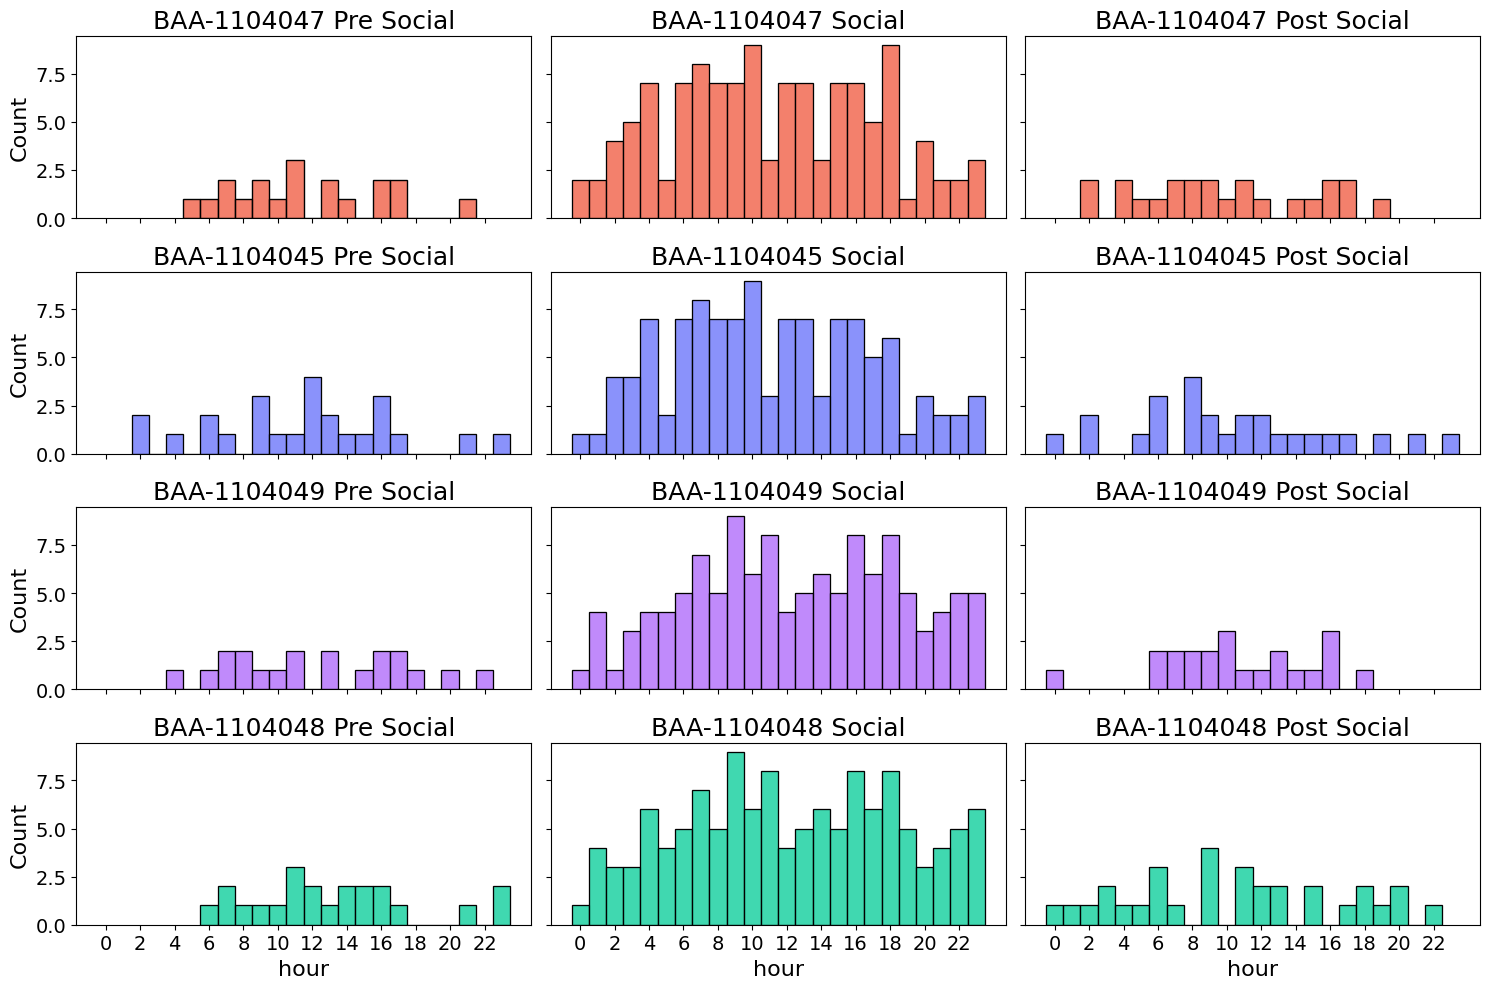

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), sharex=True, sharey=True)

# Iterate over each subject and each time condition to create histograms
for i, subject in enumerate(all_subjects):
    # Filter the DataFrame for the current subject
    df_subject = foraging_times[foraging_times["subject"] == subject]
    mask_pre = df_subject["start"] < social_start
    mask_social = (df_subject["start"] >= social_start) & (df_subject["start"] <= social_end)
    mask_post = df_subject["start"] > social_end

    # First column: before social_start
    sns.histplot(data=df_subject[mask_pre], x="hour", ax=axes[i, 0],
                 color=subject_colors_dict[subject], bins=24, discrete=True)
    axes[i, 0].set_title(f"{subject} Pre Social")

    # Second column: during social
    sns.histplot(data=df_subject[mask_social], x="hour", ax=axes[i, 1],
                 color=subject_colors_dict[subject], bins=24, discrete=True)
    axes[i, 1].set_title(f"{subject} Social")

    # Third column: after social_end
    sns.histplot(data=df_subject[mask_post], x="hour", ax=axes[i, 2],
                 color=subject_colors_dict[subject], bins=24, discrete=True)
    axes[i, 2].set_title(f"{subject} Post Social")

# Set labels and titles
for ax in axes.flat:
    ax.set_xticks(range(0, 24, 2))
    #ax.set(xlabel="hour", ylabel="Count")

# Adjust layout to prevent overlap
plt.tight_layout()


In [ ]:
"""Co-foraging."""

# - Find all the times each forages (they're "in" one of the three patches)
#   - Given these times, find the times another forages (co-foraging), with some time tolerance
#     - Given these times, find when the co-foraging is at the same patch
#       (normalized by total combined time at each patch)

In [15]:
patches = ["Patch1", "Patch2", "Patch3"]
move_thresh = 2  # 2 cm wheel movement
foraging_times = pd.DataFrame(index=all_subjects, columns=["high", "medium", "low"])
foraging_times = foraging_times.map(lambda x: np.array([], dtype="datetime64[ns]"))

# for block, for subject, for patch (hi, med, lo)
for block_i in range(len(good_blocks_df)):
    block = good_blocks_df.iloc[block_i]
    for subject in all_subjects:
        for patch in patches:
            cum_wheel_dist = good_blocks_df["cum_wheel_dist"].iloc[block_i][patch].copy()
            cum_wheel_dist.index = cum_wheel_dist.index.round("S")
            cum_wheel_dist = cum_wheel_dist[~cum_wheel_dist.index.duplicated(keep="first")]
            if (subject in cum_wheel_dist.columns):
                cum_wheel_dist = cum_wheel_dist[(cum_wheel_dist[subject].diff() > move_thresh).values]
                if len(cum_wheel_dist):
                    col = "high" if good_blocks_df["patch_info"].iloc[block_i].loc[patch, "mean"] == 100 else "low"
                    col = "medium" if good_blocks_df["patch_info"].iloc[block_i].loc[patch, "mean"] == 300 else col
                    foraging_times.loc[subject, col] = np.concatenate((foraging_times.loc[subject, col], cum_wheel_dist.index))

In [16]:
foraging_times

,high,medium,low
BAA-1104047,"[2024-02-05T17:55:31.000000000, 2024-02-05T17:...","[2024-02-06T12:42:11.000000000, 2024-02-06T12:...","[2024-02-06T09:16:47.000000000, 2024-02-06T09:..."
BAA-1104045,"[2024-01-31T13:41:10.000000000, 2024-01-31T14:...","[2024-01-31T14:25:52.000000000, 2024-01-31T14:...","[2024-01-31T13:53:03.000000000, 2024-01-31T13:..."
BAA-1104049,"[2024-02-05T16:59:27.000000000, 2024-02-05T17:...","[2024-02-05T17:12:16.000000000, 2024-02-05T17:...","[2024-02-05T17:14:31.000000000, 2024-02-05T17:..."
BAA-1104048,"[2024-01-31T13:01:28.000000000, 2024-01-31T13:...","[2024-01-31T13:00:41.000000000, 2024-01-31T13:...","[2024-02-01T11:31:32.000000000, 2024-02-01T11:..."


In [240]:
def social_foraging_times(row):
    # Concatenate the arrays from "high", "medium", "low" columns
    all_times = np.concatenate([row["high"], row["medium"], row["low"]])
    # Filter to keep only the times within the specified range
    filtered_times = all_times[(all_times <= social_start)]
    return filtered_times

# Apply the function to each row
filtered_times = foraging_times.apply(social_foraging_times, axis=1)

In [238]:
co_f_r_45 = sum(np.in1d(filtered_times["BAA-1104045"], filtered_times["BAA-1104047"])) / len(filtered_times["BAA-1104045"])
co_f_r_47 = sum(np.in1d(filtered_times["BAA-1104045"], filtered_times["BAA-1104047"])) / len(filtered_times["BAA-1104047"])
co_f_r_48 = sum(np.in1d(filtered_times["BAA-1104048"], filtered_times["BAA-1104049"])) / len(filtered_times["BAA-1104048"])
co_f_r_49 = sum(np.in1d(filtered_times["BAA-1104048"], filtered_times["BAA-1104049"])) / len(filtered_times["BAA-1104049"])

In [239]:
co_f_r_45, co_f_r_47, co_f_r_48, co_f_r_49

(0.34311882812733074,
 0.18292139835226007,
 0.19058265351401169,
 0.2264789989251019)

In [241]:
"""Synthetic co-foraging rates."""

syn_co_f_r_45 = sum(np.in1d(filtered_times["BAA-1104045"], filtered_times["BAA-1104048"])) / len(filtered_times["BAA-1104045"])
syn_co_f_r_47 = sum(np.in1d(filtered_times["BAA-1104045"], filtered_times["BAA-1104048"])) / len(filtered_times["BAA-1104048"])
syn_co_f_r_48 = sum(np.in1d(filtered_times["BAA-1104047"], filtered_times["BAA-1104049"])) / len(filtered_times["BAA-1104047"])
syn_co_f_r_49 = sum(np.in1d(filtered_times["BAA-1104047"], filtered_times["BAA-1104049"])) / len(filtered_times["BAA-1104049"])

In [242]:
syn_co_f_r_45, syn_co_f_r_47, syn_co_f_r_48, syn_co_f_r_49

(0.10361535594483787,
 0.07933337138291194,
 0.160388957192355,
 0.08338175479372457)

In [245]:
subject_colors_dict["SYN-1104045"] = "black"
subject_colors_dict["SYN-1104047"] = "black"
subject_colors_dict["SYN-1104048"] = "black"
subject_colors_dict["SYN-1104049"] = "black"

In [ ]:
values = co_f_r_45, syn_co_f_r_45, co_f_r_47, syn_co_f_r_47, co_f_r_48, syn_co_f_r_48, co_f_r_49, syn_co_f_r_49
labels = ["BAA-1104045", "SYN-1104045", "BAA-1104047", "SYN-1104047", "BAA-1104048", "SYN-1104048", "BAA-1104049", "SYN-1104049"]
data = pd.DataFrame({"Labels": labels, "Values": values})
plt.figure(figsize=(10,6))
sns.barplot(x="Labels", y="Values", data=data, palette=subject_colors_dict)
plt.title("Coforaging Rates")
plt.xlabel("Subject")
plt.ylabel("Rate")
# Rotate x-label 45 degrees
plt.xticks(rotation=45)

In [146]:
def social_foraging_times(ele):
    ele = np.array(ele)
    return ele[(ele >= social_start) & (ele <= social_end)]

# Apply the function to each row
filtered_times = foraging_times.map(social_foraging_times)
filtered_times

,high,medium,low
BAA-1104045,"[2024-02-10T03:35:32.000000000, 2024-02-10T09:...","[2024-02-10T12:35:20.000000000, 2024-02-10T12:...","[2024-02-09T17:59:39.000000000, 2024-02-09T17:..."
BAA-1104047,"[2024-02-09T20:47:57.000000000, 2024-02-09T20:...","[2024-02-10T08:00:33.000000000, 2024-02-10T08:...","[2024-02-09T17:56:11.000000000, 2024-02-09T17:..."
BAA-1104048,"[2024-02-09T18:21:13.000000000, 2024-02-09T18:...","[2024-02-09T18:20:08.000000000, 2024-02-09T18:...","[2024-02-09T18:20:14.000000000, 2024-02-09T18:..."
BAA-1104049,"[2024-02-09T18:21:13.000000000, 2024-02-09T18:...","[2024-02-09T18:19:54.000000000, 2024-02-09T18:...","[2024-02-09T18:20:15.000000000, 2024-02-09T18:..."


In [159]:
co_f_r_45_47_h = (
    sum(np.in1d(filtered_times.loc["BAA-1104045", "high"], filtered_times.loc["BAA-1104047", "high"]))
    / (len(filtered_times.loc["BAA-1104045", "high"]) + len(filtered_times.loc["BAA-1104047", "high"]))
)
co_f_r_45_47_m = (
    sum(np.in1d(filtered_times.loc["BAA-1104045", "medium"], filtered_times.loc["BAA-1104047", "medium"]))
    / (len(filtered_times.loc["BAA-1104045", "medium"]) + len(filtered_times.loc["BAA-1104047", "medium"]))
)
co_f_r_45_47_l = (
    sum(np.in1d(filtered_times.loc["BAA-1104045", "low"], filtered_times.loc["BAA-1104047", "low"]))
    / (len(filtered_times.loc["BAA-1104045", "low"]) + len(filtered_times.loc["BAA-1104047", "low"]))
)
co_f_r_45_47_s = co_f_r_45_47_h + co_f_r_45_47_m + co_f_r_45_47_l
co_f_r_45_47_l /= co_f_r_45_47_s
co_f_r_45_47_m /= co_f_r_45_47_s
co_f_r_45_47_h /= co_f_r_45_47_s

co_f_r_48_49_h = (
    sum(np.in1d(filtered_times.loc["BAA-1104048", "high"], filtered_times.loc["BAA-1104049", "high"]))
    / (len(filtered_times.loc["BAA-1104048", "high"]) + len(filtered_times.loc["BAA-1104049", "high"]))
)
co_f_r_48_49_m = (
    sum(np.in1d(filtered_times.loc["BAA-1104048", "medium"], filtered_times.loc["BAA-1104049", "medium"]))
    / (len(filtered_times.loc["BAA-1104048", "medium"]) + len(filtered_times.loc["BAA-1104049", "medium"]))
)
co_f_r_48_49_l = (
    sum(np.in1d(filtered_times.loc["BAA-1104048", "low"], filtered_times.loc["BAA-1104049", "low"]))
    / (len(filtered_times.loc["BAA-1104048", "low"]) + len(filtered_times.loc["BAA-1104049", "low"]))
)
co_f_r_48_49_s = co_f_r_48_49_h + co_f_r_48_49_m + co_f_r_48_49_l
co_f_r_48_49_l /= co_f_r_48_49_s
co_f_r_48_49_m /= co_f_r_48_49_s
co_f_r_48_49_h /= co_f_r_48_49_s

In [160]:
co_f_r_45_47_h, co_f_r_45_47_m, co_f_r_45_47_l, co_f_r_48_49_h, co_f_r_48_49_m, co_f_r_48_49_l

(0.3153234921227356,
 0.32104829763550946,
 0.36362821024175496,
 0.3150977649459573,
 0.30218158096078857,
 0.38272065409325406)

In [ ]:
# Your provided values and labels
values = co_f_r_45_47_h, co_f_r_45_47_m, co_f_r_45_47_l, co_f_r_48_49_h, co_f_r_48_49_m, co_f_r_48_49_l
labels = ["45-47 : 100", "45-47 : 300", "45-47 : 500", "48-49 : 100", "48-49 : 300", "48-49 : 500"]

# Create a DataFrame
data = pd.DataFrame({"Labels": labels, "Values": values})

# Define the color palette as repeating sequence of blue, orange, red
color_palette = ["green", "orange", "red"] * (len(values) // 3)

# Create the bar plot with the custom color palette
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Labels", y="Values", data=data, palette=color_palette)

# Adding titles and labels for clarity
plt.title("Coforaging Rates by Patch Rate")
plt.xlabel("Subject-Pair : Patch Rate")
plt.ylabel("Rate")

# Define legend handles
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(color_palette[:3], ['100', '300', '500'])]

# Add the legend to the plot
plt.legend(handles=legend_handles, title="Patch Rate")

# Show the plot
plt.show()

In [53]:
start_t_pre_45 = pd.Timestamp("2024-01-31 12:59:14")
start_t_pre_47 = pd.Timestamp("2024-02-05 15:43:39")
start_t_pre_48 = pd.Timestamp("2024-01-31 12:59:06")
start_t_pre_49 = pd.Timestamp("2024-02-05 15:00:12")

stop_t_pre_45 = pd.Timestamp("2024-02-03 15:43:01")
stop_t_pre_47 = pd.Timestamp("2024-02-08 17:20:47")
stop_t_pre_48 = pd.Timestamp("2024-02-03 16:18:35")
stop_t_pre_49 = pd.Timestamp("2024-02-08 18:47:31")

start_t_soc_45 = pd.Timestamp("2024-02-09 17:44:50")
start_t_soc_47 = pd.Timestamp("2024-02-09 17:44:50")
start_t_soc_48 = pd.Timestamp("2024-02-09 18:19:02")
start_t_soc_49 = pd.Timestamp("2024-02-09 18:19:02")

stop_t_soc_45 = pd.Timestamp("2024-02-23 09:58:54")
stop_t_soc_47 = pd.Timestamp("2024-02-23 09:58:54")
stop_t_soc_48 = pd.Timestamp("2024-02-23 11:01:39")
stop_t_soc_49 = pd.Timestamp("2024-02-23 11:01:39")

start_t_post_45 = pd.Timestamp("2024-02-25 19:31:05")
start_t_post_47 = pd.Timestamp("2024-02-28 16:15:40")
start_t_post_48 = pd.Timestamp("2024-02-25 20:11:05")
start_t_post_49 = pd.Timestamp("2024-02-28 16:44:56")

stop_t_post_45 = pd.Timestamp("2024-02-28 13:54:33")
stop_t_post_47 = pd.Timestamp("2024-03-02 14:14:33")
stop_t_post_48 = pd.Timestamp("2024-02-28 13:47:24")
stop_t_post_49 = pd.Timestamp("2024-03-02 13:48:05")

In [60]:
"""Time spent foraging per exp section."""

t_spent_foraging = pd.DataFrame(
    index=all_subjects,
    columns=[
        "all_t_pre", 
        "all_t_soc", 
        "all_t_post",
        "hi_t_pre",
        "hi_t_soc",
        "hi_t_post",
        "med_t_pre",
        "med_t_soc",
        "med_t_post",
        "lo_t_pre",
        "lo_t_soc",
        "lo_t_post",
    ]
)

# for subject in all_subjects

tot_t_pre_45 = (stop_t_pre_45 - start_t_pre_45).total_seconds()
tot_t_pre_47 = (stop_t_pre_47 - start_t_pre_47).total_seconds()
tot_t_pre_48 = (stop_t_pre_48 - start_t_pre_48).total_seconds()
tot_t_pre_49 = (stop_t_pre_49 - start_t_pre_49).total_seconds()

tot_t_soc_45 = (stop_t_soc_45 - start_t_soc_45).total_seconds()
tot_t_soc_47 = (stop_t_soc_47 - start_t_soc_47).total_seconds()
tot_t_soc_48 = (stop_t_soc_48 - start_t_soc_48).total_seconds()
tot_t_soc_49 = (stop_t_soc_49 - start_t_soc_49).total_seconds()

tot_t_post_45 = (stop_t_post_45 - start_t_post_45).total_seconds()
tot_t_post_47 = (stop_t_post_47 - start_t_post_47).total_seconds()
tot_t_post_48 = (stop_t_post_48 - start_t_post_48).total_seconds()
tot_t_post_49 = (stop_t_post_49 - start_t_post_49).total_seconds()

In [196]:
t_spent_foraging.loc["BAA-1104045", "lo_t_soc"] = (
    sum((np.array(foraging_times.loc["BAA-1104045", "low"]) > start_t_soc_45)
    & (np.array(foraging_times.loc["BAA-1104045", "low"]) < stop_t_soc_45))
    / tot_t_soc_45
)

In [17]:
data = {
    "all_t_pre": [0.049854, 0.033759, 0.063077, 0.064613],
    "all_t_soc": [0.029293, 0.054928, 0.042222, 0.051141],
    "all_t_post": [0.028752, 0.040717, 0.037648, 0.037603],
    "hi_t_pre": [0.015088, 0.022171, 0.022061, 0.035974],
    "hi_t_soc": [0.013774, 0.025535, 0.015918, 0.018005],
    "hi_t_post": [0.012958, 0.014679, 0.011369, 0.008506],
    "med_t_pre": [0.006773, 0.004777, 0.007585, 0.011926],
    "med_t_soc": [0.006108, 0.010252, 0.007585, 0.012336],
    "med_t_post": [0.008073, 0.010471, 0.010318, 0.01097],
    "lo_t_pre": [0.027993, 0.006807, 0.029648, 0.016713],
    "lo_t_soc": [0.009411, 0.019141, 0.016555, 0.0208],
    "lo_t_post": [0.007092, 0.015568, 0.014142, 0.018126],
}

index = ["BAA-1104045", "BAA-1104047", "BAA-1104049", "BAA-1104048"]

t_spent_foraging = pd.DataFrame(data, index=index)

In [220]:
t_spent_foraging

,all_t_pre,all_t_soc,all_t_post,hi_t_pre,hi_t_soc,hi_t_post,med_t_pre,med_t_soc,med_t_post,lo_t_pre,lo_t_soc,lo_t_post
BAA-1104045,0.049854,0.029293,0.028752,0.015088,0.013774,0.012958,0.006773,0.006108,0.008703,0.027993,0.009411,0.007092
BAA-1104047,0.033759,0.054928,0.040717,0.022171,0.025535,0.014679,0.004777,0.010252,0.010471,0.006807,0.019141,0.015568
BAA-1104049,0.063077,0.042222,0.037648,0.022061,0.018082,0.015918,0.011369,0.007585,0.010318,0.029648,0.016555,0.011412
BAA-1104048,0.064613,0.051141,0.037603,0.035974,0.018005,0.008506,0.011926,0.012336,0.01097,0.016713,0.0208,0.018126


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


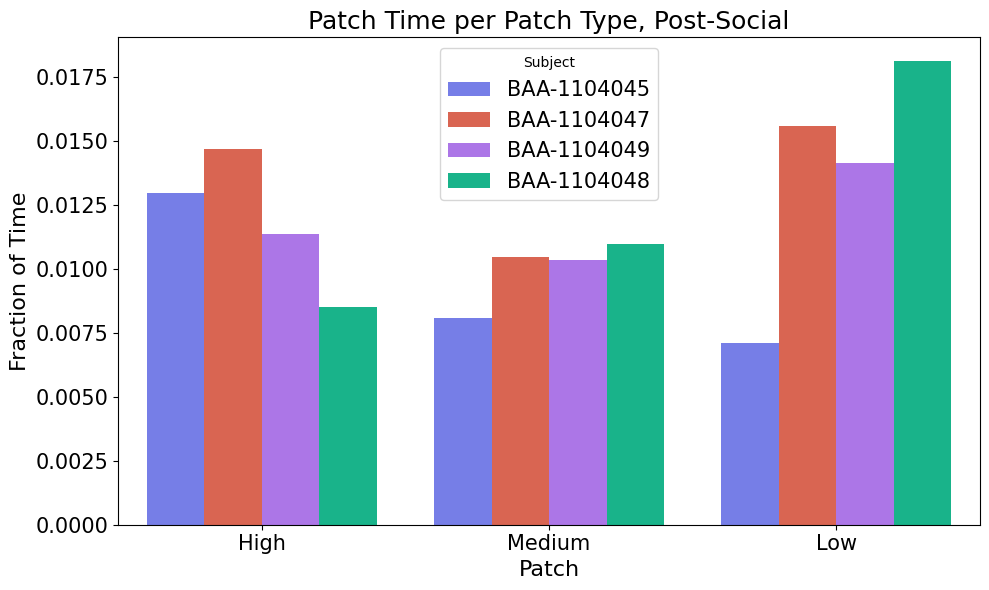

In [23]:
df = t_spent_foraging[["hi_t_post", "med_t_post", "lo_t_post"]].copy()
# Rename df columns
df.columns = ['High', 'Medium', 'Low']

# Melt the DataFrame to long format
df_long = df.reset_index().melt(id_vars='index', var_name='Time Condition', value_name='Value')

# Set the order for the time conditions
time_order = df.columns

# Create the bar plot with seaborn
plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
ax = sns.barplot(
    data=df_long,
    x='Time Condition',
    y='Value',
    hue='index',
    palette=subject_colors_dict,
    order=time_order  # Order the groups as per the list above
)

# Add legend title
ax.legend(title='Subject')

# Set the plot title and labels
ax.set_title('Patch Time per Patch Type, Post-Social')
ax.set_xlabel('Patch')
ax.set_ylabel('Fraction of Time')

# # Customize the bar edges
# for bar in ax.patches:
#     bar.set_linewidth(1)
#     bar.set_edgecolor('black')  # You can change 'black' to any valid color string

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure ev

In [40]:
np.unique(block.patch_info["mean"])

array([100.0, 300.0, 500.0], dtype=object)

In [41]:
patch_foraging = pd.DataFrame(columns=["Block_i", "Subject", "High", "Medium", "Low", "Patch1", "Patch2", "Patch3"])

for block_i, block in enumerate(good_blocks_df_cp.itertuples()):
    if len(np.unique(block.patch_info["mean"])) == 1:  # only look at blocks with all patches different vals
        continue
    high_p, med_p, low_p = block.patch_info.sort_values("mean").index
    n_pellets = len(block.pellet_info)
    pellet_info = block.pellet_info.sort_values("time")
    halfway_ts = pellet_info["time"].iloc[n_pellets // 2]
    cum_wheel_dist = good_blocks_df["cum_wheel_dist"].loc[block.Index]
    for subj in block.subjects:
        cur_block = {}
        cur_block["Block_i"] = block_i
        cur_block["Subject"] = subj
        high_dist = cum_wheel_dist[high_p][subj]
        high_dist = (
            high_dist[high_dist.index > halfway_ts].iloc[-1]
            - high_dist[high_dist.index > halfway_ts].iloc[0]
        )
        high_dist = 1 if high_dist < 0 else high_dist
        med_dist = cum_wheel_dist[med_p][subj]
        med_dist = (
            med_dist[med_dist.index > halfway_ts].iloc[-1]
            - med_dist[med_dist.index > halfway_ts].iloc[0]
        )
        med_dist = 1 if med_dist < 0 else med_dist
        low_dist = cum_wheel_dist[low_p][subj]
        low_dist = (
            low_dist[low_dist.index > halfway_ts].iloc[-1]
            - low_dist[low_dist.index > halfway_ts].iloc[0]
        )
        low_dist = 1 if low_dist < 0 else low_dist
        cur_block["Total"] = sum((high_dist, med_dist, low_dist))
        cur_block["High"] = high_dist / cur_block["Total"]
        cur_block["Medium"] = med_dist / cur_block["Total"]
        cur_block["Low"] = low_dist / cur_block["Total"]
        patch_number_rate_dict = {}
        number_keys = ["Patch1", "Patch2", "Patch3"]
        for key, val in zip([high_p, med_p, low_p], [high_dist, med_dist, low_dist]):
            patch_number_rate_dict[key] = val
        cur_block["Patch1"] = patch_number_rate_dict["Patch1"] / cur_block["Total"]
        cur_block["Patch2"] = patch_number_rate_dict["Patch2"] / cur_block["Total"]
        cur_block["Patch3"] = patch_number_rate_dict["Patch3"] / cur_block["Total"]
        patch_foraging = pd.concat([patch_foraging, pd.DataFrame(cur_block, index=[0])], ignore_index=True)

C:\Users\jai\AppData\Local\Temp\ipykernel_4968\2067877676.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  patch_foraging = pd.concat([patch_foraging, pd.DataFrame(cur_block, index=[0])], ignore_index=True)
C:\Users\jai\AppData\Local\Temp\ipykernel_4968\2067877676.py:34: RuntimeWarning: invalid value encountered in scalar divide
  cur_block["High"] = high_dist / cur_block["Total"]
C:\Users\jai\AppData\Local\Temp\ipykernel_4968\2067877676.py:35: RuntimeWarning: invalid value encountered in scalar divide
  cur_block["Medium"] = med_dist / cur_block["Total"]
C:\Users\jai\AppData\Local\Temp\ipykernel_4968\2067877676.py:36: RuntimeWarning: invalid value encountered in scalar divide
  cur_block["Low"] = low_dist / cur_block["Total"]
C:\Users\

In [42]:
patch_foraging

,Block_i,Subject,High,Medium,Low,Patch1,Patch2,Patch3,Total
0,0,BAA-1104048,0.999618,0.000381,9.257506e-07,0.999618,9.257506e-07,0.000381,3314.228184
1,1,BAA-1104045,0.998886,0.000557,5.568984e-04,0.998886,5.568984e-04,0.000557,1795.659755
2,2,BAA-1104045,0.999482,0.000003,5.151410e-04,0.999482,5.151410e-04,0.000003,1941.216021
3,4,BAA-1104045,0.999368,0.000002,6.297558e-04,0.000630,1.932184e-06,0.999368,1587.917148
4,5,BAA-1104048,0.999966,0.000020,1.355859e-05,0.000020,1.355859e-05,0.999966,226.288250
...,...,...,...,...,...,...,...,...,...
526,422,BAA-1104049,0.722181,0.015976,2.618433e-01,0.722181,2.618433e-01,0.015976,2168.375841
527,425,BAA-1104047,0.998773,0.000207,1.019564e-03,0.000207,9.987730e-01,0.001020,1146.533472
528,426,BAA-1104049,0.028481,0.493720,4.777991e-01,0.477799,4.937201e-01,0.028481,5166.848556
529,427,BAA-1104047,0.274046,0.582385,1.435684e-01,0.274046,1.435684e-01,0.582385,7432.418750


In [50]:
group

,Block_i,Subject,High,Medium,Low,Patch1,Patch2,Patch3,Total
1,1,BAA-1104045,0.998886,5.568984e-04,5.568984e-04,0.998886,5.568984e-04,5.568984e-04,1795.659755
2,2,BAA-1104045,0.999482,3.161059e-06,5.151410e-04,0.999482,5.151410e-04,3.161059e-06,1941.216021
3,4,BAA-1104045,0.999368,1.932184e-06,6.297558e-04,0.000630,1.932184e-06,9.993683e-01,1587.917148
5,7,BAA-1104045,0.000000,9.999934e-01,6.629893e-06,0.999993,0.000000e+00,6.629893e-06,231.387513
7,9,BAA-1104045,0.738800,3.307866e-04,2.608695e-01,0.738800,3.307866e-04,2.608695e-01,3023.097461
...,...,...,...,...,...,...,...,...,...
489,380,BAA-1104045,0.421519,3.876173e-02,5.397197e-01,0.038762,4.215185e-01,5.397197e-01,1175.358730
491,382,BAA-1104045,0.999998,8.407049e-07,8.407049e-07,0.999998,8.407049e-07,8.407049e-07,1824.747773
492,383,BAA-1104045,0.912115,1.971146e-03,8.591427e-02,0.912115,8.591427e-02,1.971146e-03,4644.687975
495,386,BAA-1104045,0.997250,1.821079e-03,9.288625e-04,0.997250,1.821079e-03,9.288625e-04,1076.585598


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

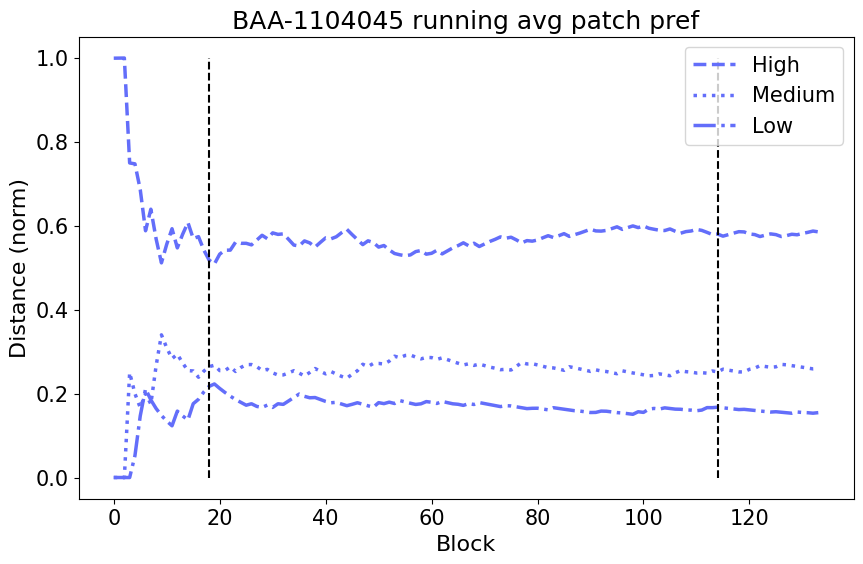

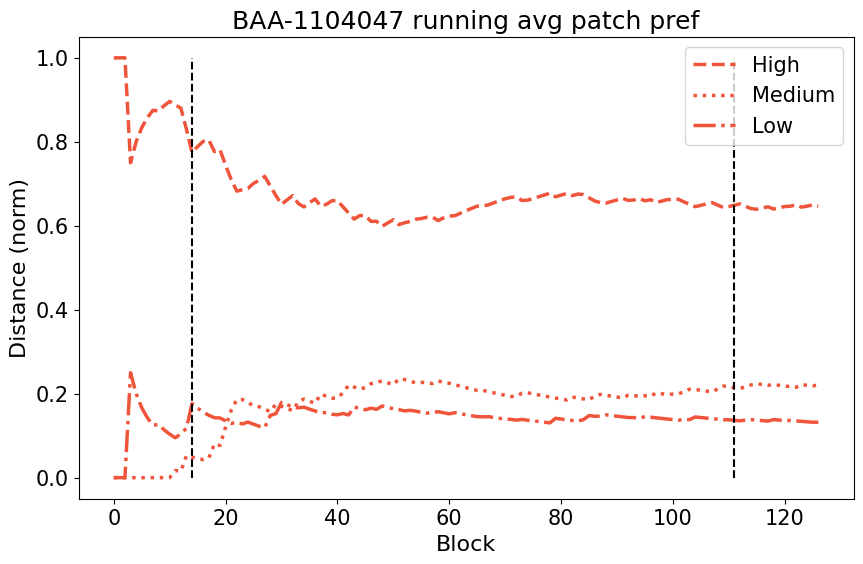

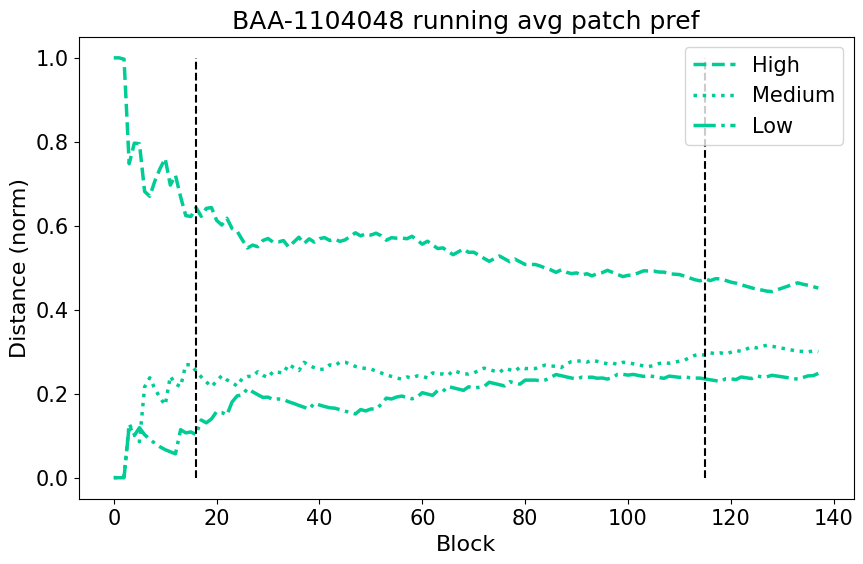

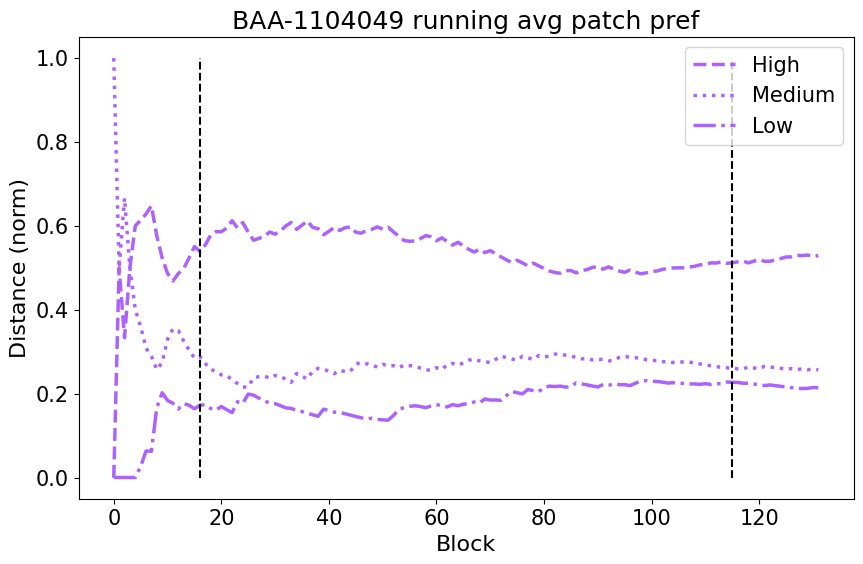

In [51]:
linestyles = {
    "High": "dashed",
    "Medium": "dotted",
    "Low": "dashdot"
}


# Group by 'Subject' and create plots
for subject, group in patch_foraging.groupby('Subject'):
    # Start a new figure
    plt.figure(figsize=(10, 6))

    # Plot each feature with running average
    for feature in ['High', 'Medium', 'Low']:
        # Calculate the running average
        running_avg = group[feature].expanding().mean()
        # Plot the running average using seaborn lineplot
        ax = sns.lineplot(
            x=range(len(group)),
            y=running_avg,
            label=feature,
            color=subject_colors_dict[subject],
            linestyle=linestyles[feature],
            linewidth=2.5
        )
    ax.vlines(x=vline_blocks[subject][0], ymin=0, ymax=1, linestyles="dashed", colors="black")
    ax.vlines(x=vline_blocks[subject][1], ymin=0, ymax=1, linestyles="dashed", colors="black")

    # Customize the plot with title and labels
    plt.title(f'{subject} running avg patch pref')
    plt.xlabel('Block')
    plt.ylabel('Distance (norm)')
    plt.legend()

In [46]:
df

,Block_i,Subject,High,Medium,Low,Patch1,Patch2,Patch3,Total
0,0,BAA-1104048,0.999618,0.000381,9.257506e-07,0.999618,9.257506e-07,0.000381,3314.228184
1,1,BAA-1104045,0.998886,0.000557,5.568984e-04,0.998886,5.568984e-04,0.000557,1795.659755
2,2,BAA-1104045,0.999482,0.000003,5.151410e-04,0.999482,5.151410e-04,0.000003,1941.216021
3,4,BAA-1104045,0.999368,0.000002,6.297558e-04,0.000630,1.932184e-06,0.999368,1587.917148
4,5,BAA-1104048,0.999966,0.000020,1.355859e-05,0.000020,1.355859e-05,0.999966,226.288250
...,...,...,...,...,...,...,...,...,...
526,422,BAA-1104049,0.722181,0.015976,2.618433e-01,0.722181,2.618433e-01,0.015976,2168.375841
527,425,BAA-1104047,0.998773,0.000207,1.019564e-03,0.000207,9.987730e-01,0.001020,1146.533472
528,426,BAA-1104049,0.028481,0.493720,4.777991e-01,0.477799,4.937201e-01,0.028481,5166.848556
529,427,BAA-1104047,0.274046,0.582385,1.435684e-01,0.274046,1.435684e-01,0.582385,7432.418750


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

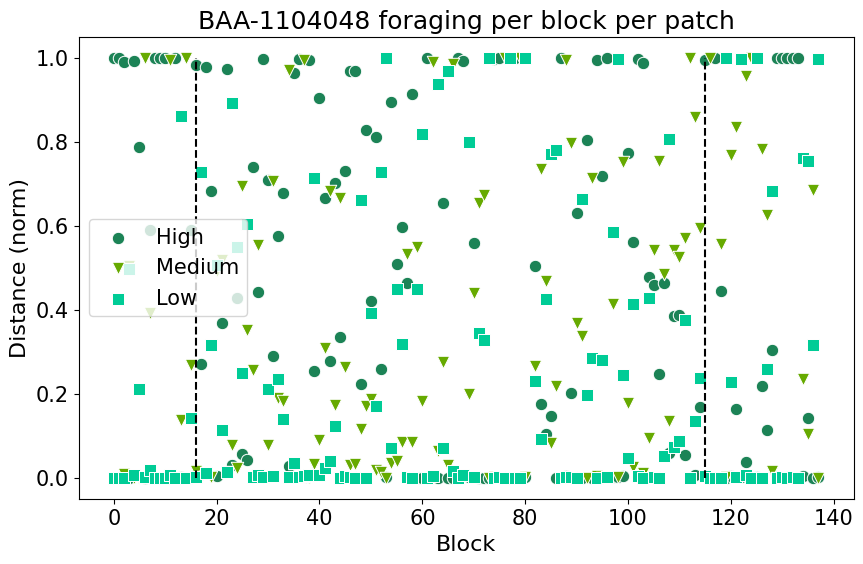

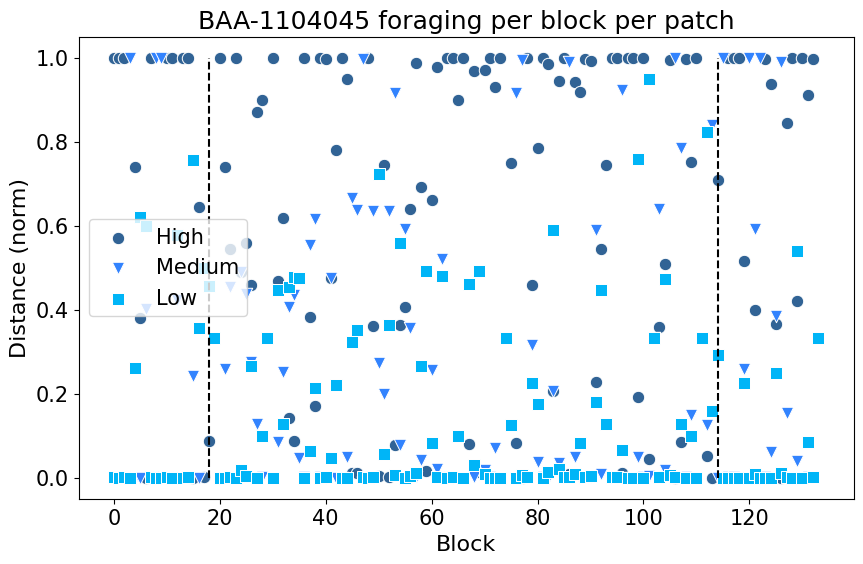

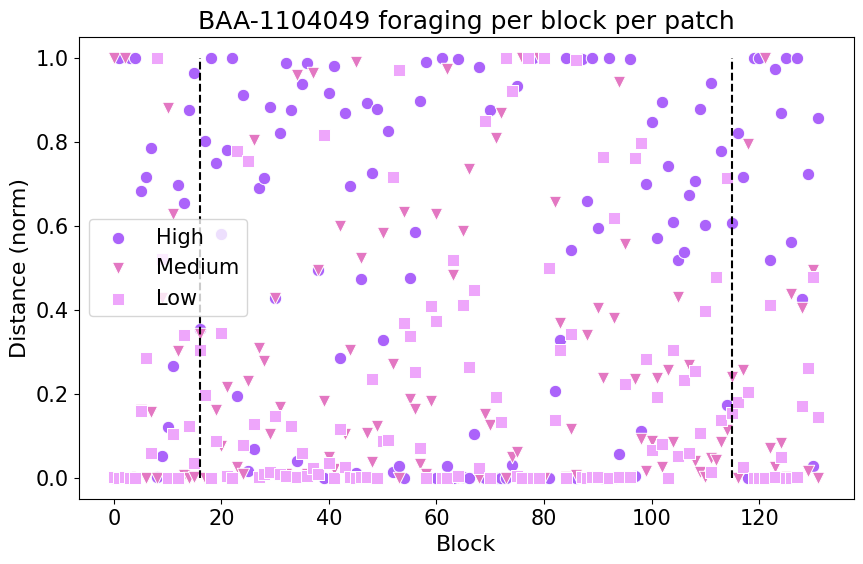

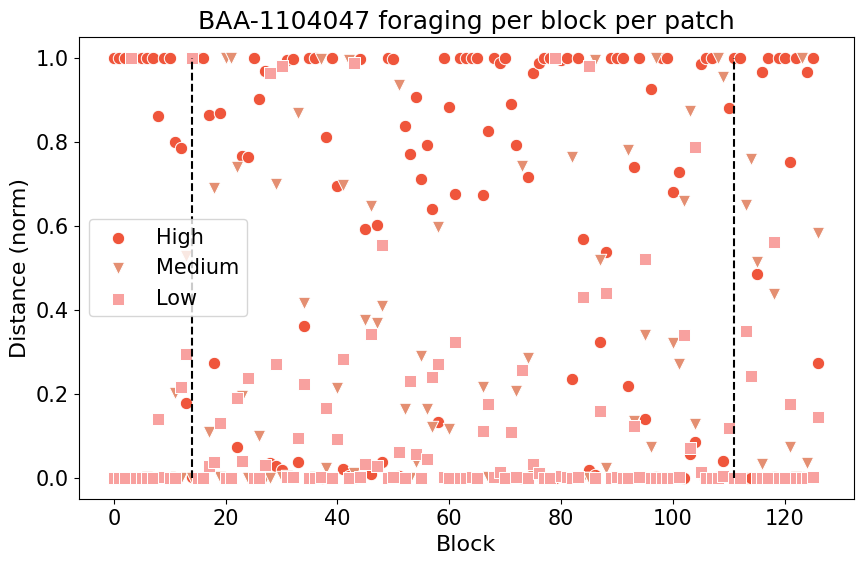

In [47]:
# Define linestyles
linestyles = {
    "High": "o",
    "Medium": "v",
    "Low": "s"
}

colors = {
    "BAA-1104045": {
        "High": "#316395",
        "Medium": "#3283FE",
        "Low": "#00B5F7",
    },
    "BAA-1104047": {
        "High": "#EF553B",
        "Medium": "#E48F72",
        "Low": "#F8A19F",
    },
    "BAA-1104048": {
        "High": "#1C8356",
        "Medium": "#66AA00",
        "Low": "#00CC96",
    },
    "BAA-1104049": {
        "High": "#AB63FA",
        "Medium": "#E377C2",
        "Low": "#EEA6FB",
    },
}

vline_blocks = {
    "BAA-1104045": [18, 114],
    "BAA-1104047": [14, 111],
    "BAA-1104048": [16, 115],
    "BAA-1104049": [16, 115]
}

# Loop through each subject
df = patch_foraging
for subject in df["Subject"].unique():
    # Filter the DataFrame for the current subject
    subject_df = df[df["Subject"] == subject]

    # Create a new figure for each subject
    plt.figure(figsize=(10, 6))

    # Plot each of the 'High', 'Medium', and 'Low' columns
    for col, ls in linestyles.items():
        ax = sns.scatterplot(
            data=subject_df,
            #x=subject_df.index,
            x=range(len(subject_df)),
            y=col,
            marker=ls,
            s=80,
            color=colors[subject][col],
            label=col,
        )
    ax.vlines(x=vline_blocks[subject][0], ymin=0, ymax=1, linestyles="dashed", colors="black")
    ax.vlines(x=vline_blocks[subject][1], ymin=0, ymax=1, linestyles="dashed", colors="black")

    # Add title and format the plot
    plt.title(f"{subject} foraging per block per patch")
    plt.xlabel("Block")
    plt.ylabel("Distance (norm)")
    plt.legend(loc="center left")

    # Shade instead of diff markers?

In [11]:
block_type_foraging = pd.DataFrame(
    columns=[
        "Block_type",
        "Block_duration",
        "Subjects",
        "Total_distance",
        "N_Pellets"
    ]
)

for block_i, block in enumerate(good_blocks_df_cp.itertuples()):
    cur_block = pd.DataFrame(index=["0"], columns=block_type_foraging.columns)
    if np.all(np.unique(block.patch_info["mean"]) == 100):
         cur_block.loc["0", "Block_type"] = "HHH"
    elif np.all(np.unique(block.patch_info["mean"]) == 500):
        cur_block.loc["0", "Block_type"] = "LLL"
    else:
        cur_block.loc["0", "Block_type"] = "HML"
    cur_block.loc["0", "Block_duration"] = block.block_duration
    cur_block.loc["0", "Subjects"] = block.subjects
    cum_wheel_dist = good_blocks_df["cum_wheel_dist"].loc[block.Index]
    p1_dist = cum_wheel_dist.Patch1.iloc[-1].sum()
    p2_dist = cum_wheel_dist.Patch2.iloc[-1].sum()
    p3_dist = cum_wheel_dist.Patch3.iloc[-1].sum()
    cur_block.loc["0", "Total_distance"] = tot_dist = p1_dist + p2_dist + p3_dist
    cur_block.loc["0", "N_Pellets"] = len(block.pellet_info)
    block_type_foraging = pd.concat([block_type_foraging, cur_block], ignore_index=True)


In [12]:
block_type_foraging = block_type_foraging[block_type_foraging["Block_duration"] < pd.Timedelta("3 hours")]

In [13]:
block_type_foraging

,Block_type,Block_duration,Subjects,Total_distance,N_Pellets
0,HML,0 days 01:59:05.039999962,[BAA-1104048],8988.490264,44
1,HML,0 days 01:46:44.998015881,[BAA-1104045],5502.487164,23
2,HML,0 days 01:32:16.001984119,[BAA-1104045],5029.771336,32
3,HHH,0 days 02:51:18.954016209,[BAA-1104048],7650.140728,46
4,HML,0 days 01:38:15.998015881,[BAA-1104045],5726.977479,23
...,...,...,...,...,...
424,HHH,0 days 01:34:43.003999710,[BAA-1104049],8144.980978,50
425,HML,0 days 01:12:17,[BAA-1104047],3246.975896,21
426,HML,0 days 01:01:27.994016171,[BAA-1104049],9906.026311,19
427,HML,0 days 02:04:30.003999710,[BAA-1104047],19592.790433,62


In [14]:
block_type_foraging["norm_dist"] = (
    block_type_foraging["Total_distance"]
    / (block_type_foraging["Block_duration"].apply(lambda x: x.total_seconds()) / 3600) 
    / block_type_foraging["Subjects"].apply(lambda x: len(x))
)

In [15]:
block_type_foraging

,Block_type,Block_duration,Subjects,Total_distance,N_Pellets,norm_dist
0,HML,0 days 01:59:05.039999962,[BAA-1104048],8988.490264,44,4528.815088
1,HML,0 days 01:46:44.998015881,[BAA-1104045],5502.487164,23,3092.733791
2,HML,0 days 01:32:16.001984119,[BAA-1104045],5029.771336,32,3270.803887
3,HHH,0 days 02:51:18.954016209,[BAA-1104048],7650.140728,46,2679.310227
4,HML,0 days 01:38:15.998015881,[BAA-1104045],5726.977479,23,3496.798824
...,...,...,...,...,...,...
424,HHH,0 days 01:34:43.003999710,[BAA-1104049],8144.980978,50,5159.583123
425,HML,0 days 01:12:17,[BAA-1104047],3246.975896,21,2695.207107
426,HML,0 days 01:01:27.994016171,[BAA-1104049],9906.026311,19,9669.672609
427,HML,0 days 02:04:30.003999710,[BAA-1104047],19592.790433,62,9442.303588


In [ ]:
df = block_type_foraging.copy()
# Apply `len("Subjects")` to `df`
df["N_Subjects"] = df["Subjects"].apply(len)
# Only keep blocks with N_Subjects < 2
df = df[df["N_Subjects"] < 2]
# Only keep "LLL" block_type
df = df[df["Block_type"] == "LLL"]
df["Subjects"] = df["Subjects"].apply(lambda x: x[0])
df["block_number"] = df.groupby("Subjects").cumcount()

# Group by unique subject and create one line plot per subject of "norm_dist"
# for subject, group in df.groupby("Subjects"):
plt.figure(figsize=(10, 6))  # Set the figure size
ax = sns.lineplot(
    data=df,
    x="block_number",
    y="norm_dist",
    hue="Subjects",
    palette=subject_colors_dict,
    #marker="o",
    #markersize=10,
    #label="Subjects"
)
ax.set_title(f"{subject} L,L,L block foraging over time")
ax.set_xlabel("Block")
ax.set_ylabel("Distance (cm / hour)")

In [ ]:
df = block_type_foraging.copy()
# Apply `len("Subjects")` to `df`
df["N_Subjects"] = df["Subjects"].apply(len)
# only keep HHH blocks
df = df[df["N_Subjects"] == "HHH"]

# Plotting one distribution curve per block_type
plt.figure(figsize=(10, 6))  # Set the figure size
ax = sns.histplot(
    data=df,
    x="norm_dist",
    hue="N_Subjects",
    kde=True,
    kde_kws={"bw_adjust": 0.5},
    binwidth=250,
    palette=plotly.colors.qualitative.D3
)

# Adding labels and title
# ax.set_yticks((np.arange(0, 23, 2)))
plt.xlabel("Total Distance Foraged (cm / subject / hour)")
plt.ylabel("Count")
plt.title("'H, H, H' Blocks Individual vs. Social: Total Distance Foraged")

In [ ]:
# Plotting one distribution curve per block_type
plt.figure(figsize=(10, 6))  # Set the figure size
# Plot the KDE
label = block_type_foraging["Block_type"]
ax = sns.histplot(
    data=block_type_foraging, 
    x="norm_dist",
    hue="Block_type", 
    kde=True, 
    kde_kws={"bw_adjust": 0.5}, 
    binwidth=250,
    palette=["orange", "green", "red"]
)

# Adding labels and title
ax.set_yticks((np.arange(0,23,2)))
plt.xlabel('Total Distance Foraged (cm / subject / hour)')
plt.ylabel('Count')
plt.title('Total Distance Foraged by Block Type')

In [90]:
block_type_foraging = pd.DataFrame(
    columns=[  # all distances normalized by block duration
        "Exp_section",
        "Block_duration",
        "Subject",
        "High",
        "Medium",
        "Low",
        "Total",
    ]
)

for block_i, block in enumerate(good_blocks_df_cp.itertuples()):
    if len(np.unique(block.patch_info["mean"])) == 1:  # only look at blocks with all patches different vals
        continue
    cur_block = pd.DataFrame(index=["0"], columns=block_type_foraging.columns)
    if (len(block.subjects) < 2) and (block_i < 200):
        cur_block.loc["0", "Exp_section"] = "pre-social"
    elif (len(block.subjects) < 2) and (block_i > 200):
        cur_block.loc["0", "Exp_section"] = "post-social"
    else:
        cur_block.loc["0", "Exp_section"] = "social"
    cur_block.loc["0", "Block_duration"] = block.block_duration
    cum_wheel_dist = good_blocks_df["cum_wheel_dist"].loc[block.Index]
    high_p = patch_info[patch_info["mean"] == 100].index[0]
    med_p =  patch_info[patch_info["mean"] == 300].index[0]
    low_p = patch_info[patch_info["mean"] == 500].index[0]
    tot_h = block.block_duration.total_seconds() / 3600
    for subject in block.subjects:
        cur_block.loc["0", "Subject"] = subject
        w_high = int(cum_wheel_dist[high_p][subject].iloc[-1]) + 1
        w_med = int(cum_wheel_dist[med_p][subject].iloc[-1]) + 1
        w_low = int(cum_wheel_dist[low_p][subject].iloc[-1]) + 1
        tot_dist = w_high + w_med + w_low
        cur_block.loc["0", "Total"] = tot_dist / tot_h
        cur_block.loc["0", "High"] = w_high / tot_h
        cur_block.loc["0", "Medium"] = w_med / tot_h
        cur_block.loc["0", "Low"] = w_low / tot_h
        block_type_foraging = pd.concat([block_type_foraging, cur_block], ignore_index=True)

In [83]:
block_type_foraging

,Exp_section,Block_duration,Subject,High,Medium,Low,Total
0,pre-social,0 days 01:59:05.039999962,BAA-1104048,2746.968527,1782.103389,0.503846,4529.575762
1,pre-social,0 days 01:46:44.998015881,BAA-1104045,1803.653955,1248.899684,41.030458,3093.584097
2,pre-social,0 days 01:32:16.001984119,BAA-1104045,3269.652007,1.950866,0.650289,3272.253163
3,pre-social,0 days 01:38:15.998015881,BAA-1104045,2004.546129,1459.294928,34.192685,3498.033742
4,pre-social,0 days 02:51:23.007999897,BAA-1104048,12.953408,459.320852,0.350092,472.624353
...,...,...,...,...,...,...,...
330,post-social,0 days 01:47:00.976000309,BAA-1104049,1865.884563,68.400816,1127.492144,3061.777524
331,post-social,0 days 01:12:17,BAA-1104047,0.830067,80.516486,2615.540696,2696.887249
332,post-social,0 days 01:01:27.994016171,BAA-1104049,4814.324514,286.985281,4570.289411,9671.599207
333,post-social,0 days 02:04:30.003999710,BAA-1104047,983.132004,5169.635787,3290.600648,9443.368439


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

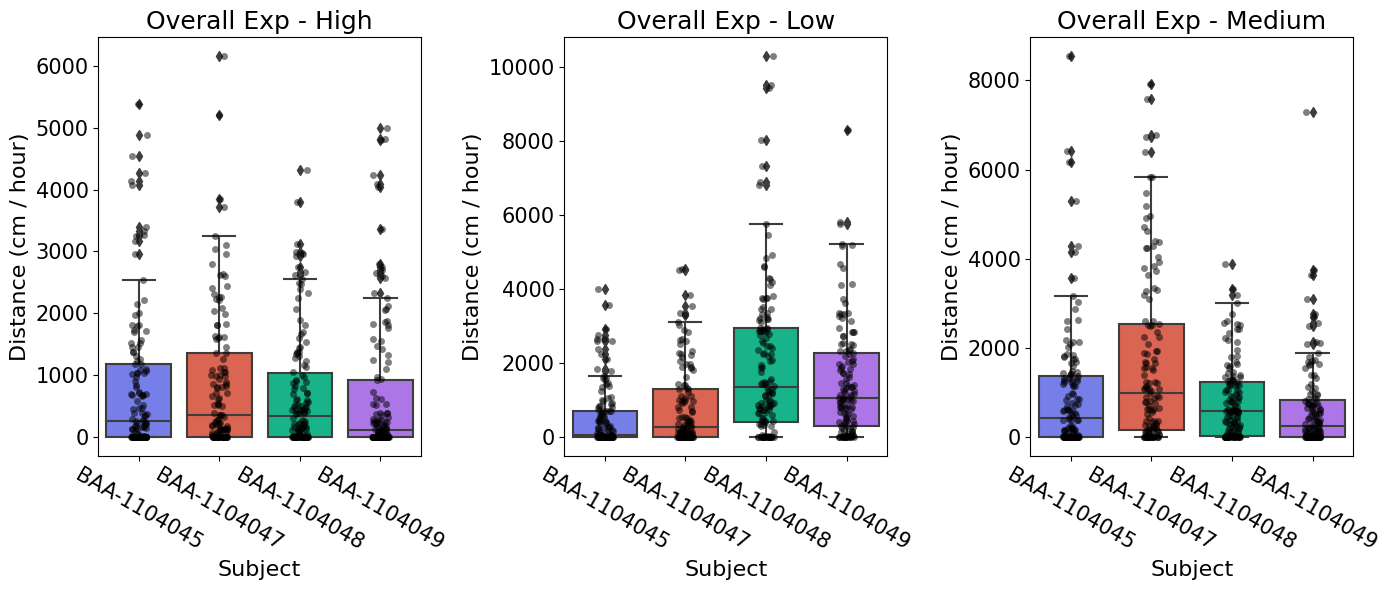

In [98]:
# Start a new figure
plt.figure(figsize=(14, 6))

dist_columns = ["High", "Low", "Medium"]
# Plotting each distribution group
for i, dist_col in enumerate(dist_columns, 1):
    plt.subplot(1, len(dist_columns), i)
    ax = sns.boxplot(
        data=block_type_foraging,
        x='Subject',
        y=dist_col,
        palette=subject_colors_dict,
        order=subject_order
    )
    sns.stripplot(
        data=block_type_foraging,
        x="Subject",
        y=dist_col,
        color="black",
        alpha=0.5,
        order=subject_order,
    )
    plt.xticks(rotation=-30)
    plt.title(f'Overall Exp - {dist_col}')
    plt.xlabel('Subject')
    plt.ylabel("Distance (cm / hour)")

# Adjust the layout and display the plot
plt.tight_layout()

c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

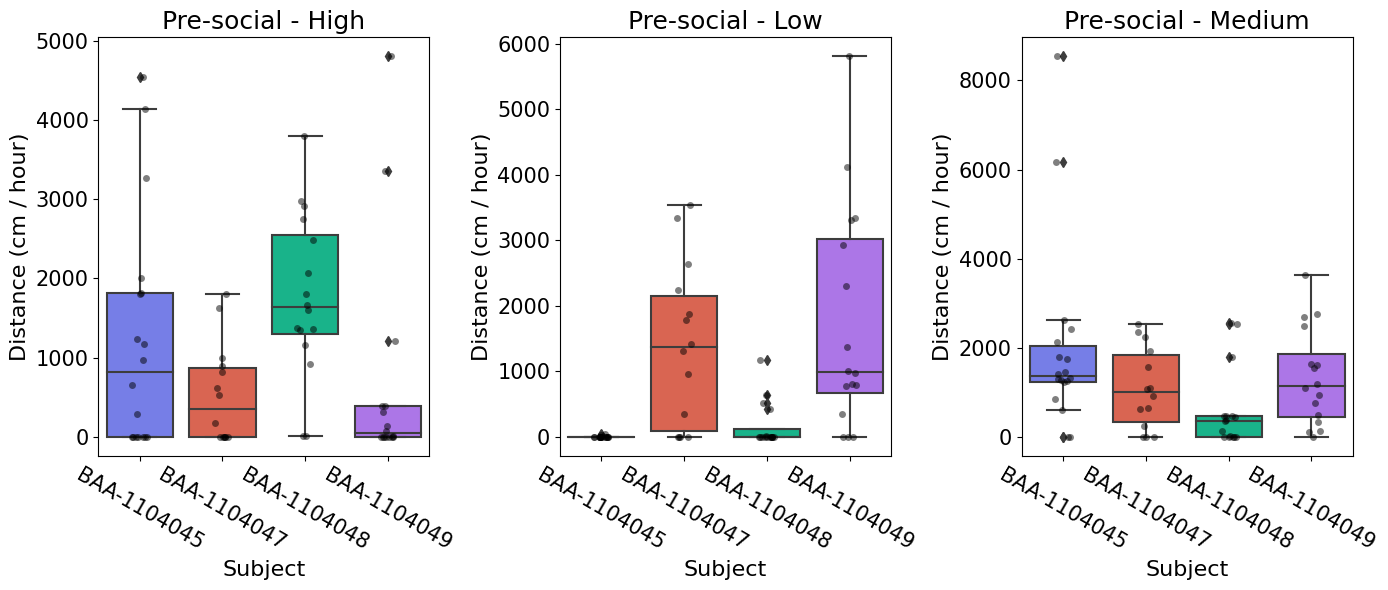

c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

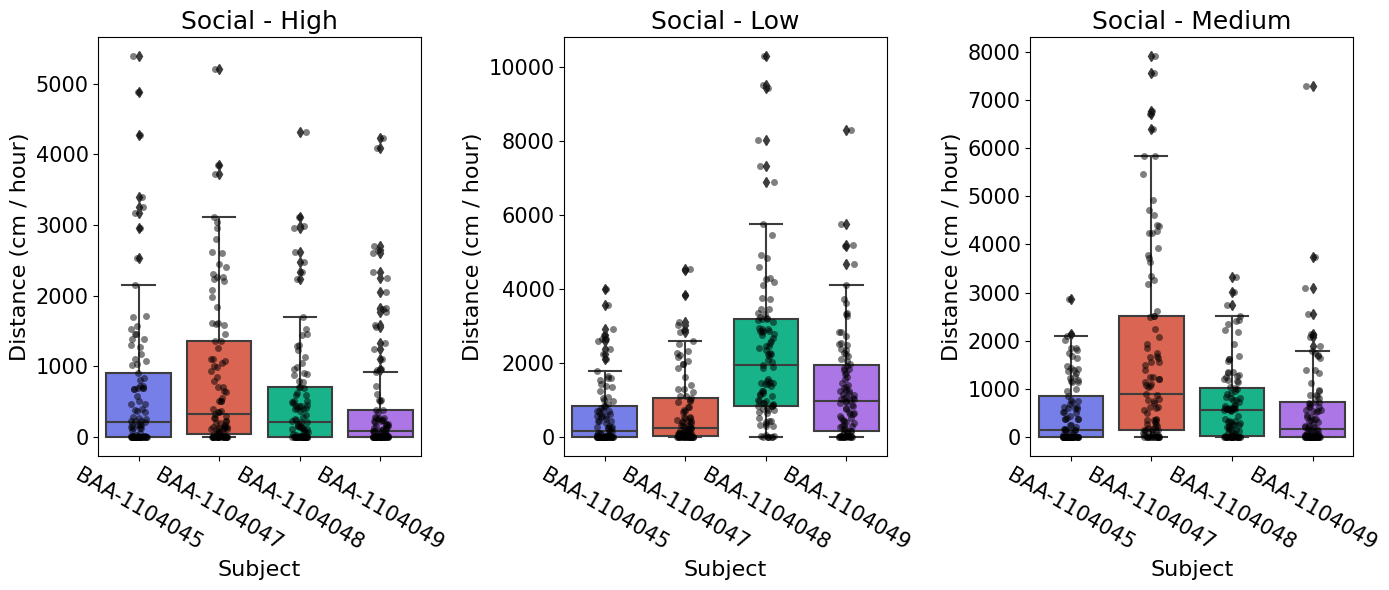

c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

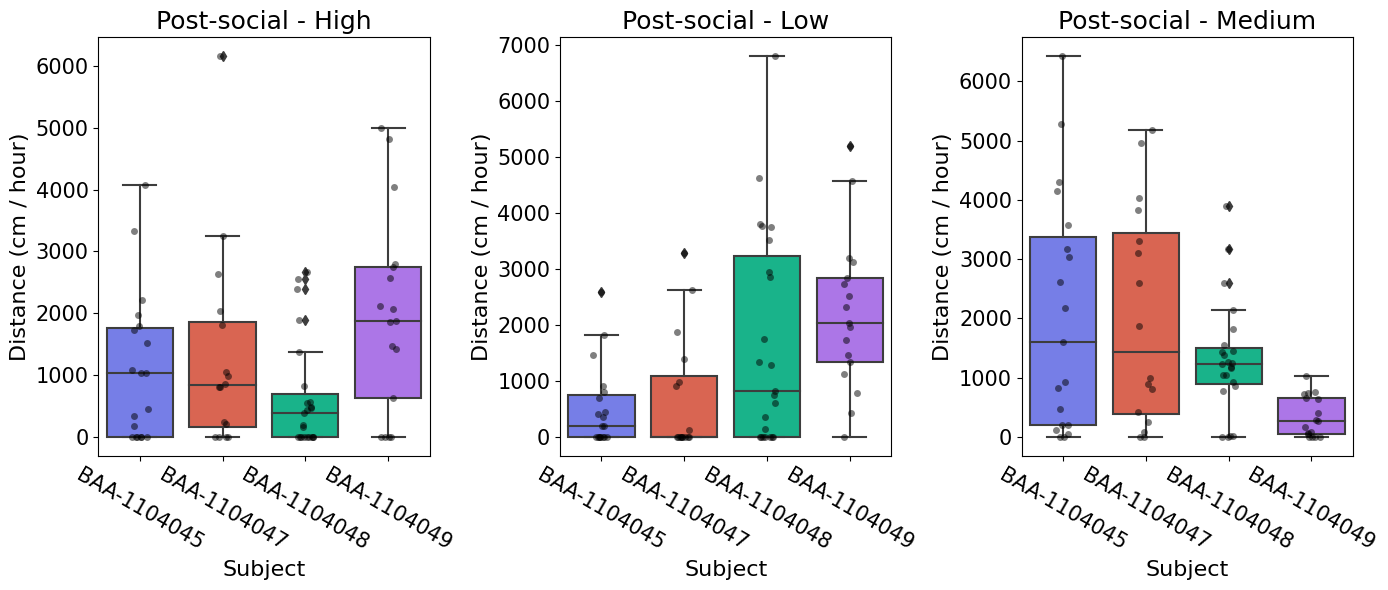

In [99]:
df = block_type_foraging
# Ensure the distance columns are numeric
for col in ['High', 'Medium', 'Low']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=['High', 'Medium', 'Low'], inplace=True)
# Unique sections to create separate plots for
exp_sections = ['pre-social', 'social', 'post-social']
# Unique groups for violin plots
#dist_columns = ['High', 'Medium', 'Low']
subject_order = ["BAA-1104045", "BAA-1104047", "BAA-1104048", "BAA-1104049"]
# Loop through each experience section to create separate figures
for section in exp_sections:
    # Filter the DataFrame for the current section
    section_df = df[df['Exp_section'] == section]

    # Start a new figure
    plt.figure(figsize=(14, 6))

    # Plotting each distribution group
    for i, dist_col in enumerate(dist_columns, 1):
        plt.subplot(1, len(dist_columns), i)
        ax = sns.boxplot(
            data=section_df,
            x='Subject',
            y=dist_col,
            palette=subject_colors_dict,
            order=subject_order
        )
        sns.stripplot(
            data=section_df,
            x="Subject",
            y=dist_col,
            color="black",
            alpha=0.5,
            order=subject_order,
        )
        plt.xticks(rotation=-30)
        plt.title(f'{section.capitalize()} - {dist_col}')
        plt.xlabel('Subject')
        plt.ylabel("Distance (cm / hour)")

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

## Social Hierarchy

In [27]:
dominance_scores = pd.DataFrame(index=list(all_subjects), columns=["pre-social", "post-social"])
dominance_scores.loc["BAA-1104047"] = 0.8, 0.9
dominance_scores.loc["BAA-1104045"] = 0.2, 0.1
dominance_scores.loc["BAA-1104048"] = 0.7, 0.8
dominance_scores.loc["BAA-1104049"] = 0.3, 0.2

In [28]:
dominance_scores

,pre-social,post-social
BAA-1104048,0.7,0.8
BAA-1104049,0.3,0.2
BAA-1104047,0.8,0.9
BAA-1104045,0.2,0.1


In [70]:
plt.rc("axes", titlesize=19)
plt.rc("axes", labelsize=18)
plt.rc("legend", fontsize=15)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

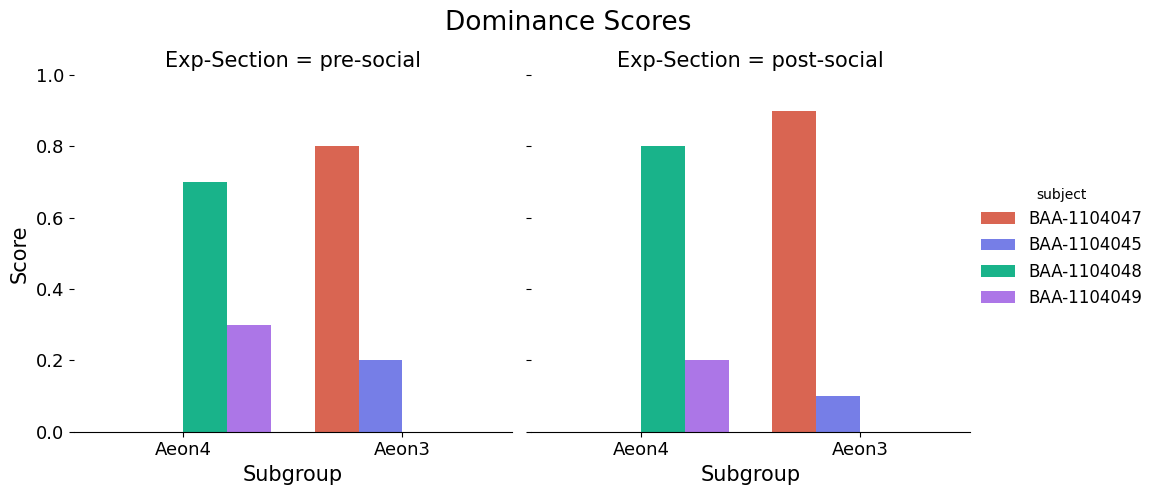

In [43]:
dominance_scores_reset = dominance_scores.reset_index()
dominance_scores_reset = dominance_scores_reset.rename(columns={"index": "subject"})

dominance_scores_long = pd.melt(
    dominance_scores_reset, 
    id_vars="subject", 
    value_vars=["pre-social", "post-social"],
    var_name="Exp-Section", 
    value_name="Score"
)

dominance_scores_long["Exp-Section"] = pd.Categorical(dominance_scores_long["Exp-Section"], ["pre-social", "post-social"])
dominance_scores_long["colors"] = dominance_scores_long["subject"].map(subject_colors_dict)
# Define subgroupings
subgroup_dict = {
    "BAA-1104047": "Aeon3",
    "BAA-1104045": "Aeon3",
    "BAA-1104048": "Aeon4",
    "BAA-1104049": "Aeon4",
}
dominance_scores_long["Subgroup"] = dominance_scores_long["subject"].map(subgroup_dict)
subject_order = ["BAA-1104047", "BAA-1104045", "BAA-1104048", "BAA-1104049"]
dominance_scores_long["subject"] = pd.Categorical(
    dominance_scores_long["subject"], categories=subject_order, ordered=True
)

# Create catplot
ax = sns.catplot(
    x="Subgroup", 
    y="Score", 
    hue="subject",
    col="Exp-Section",  # separate plots for "Time"
    data=dominance_scores_long, 
    kind="bar",
    palette=subject_colors_dict, 
    dodge=True  # separate bars within subgroups
)

# Prettify
ax.set(ylim=(0,1))
# ax.add_legend(title="Subject", fontsize=14)  # fix legend
#ax.set_axis_labels("", "Score")
ax.fig.suptitle("Dominance Scores", fontsize=19)
plt.subplots_adjust(top=0.85)
ax.despine(left=True)  # Remove the left spine

## Other

In [7]:
cum_wheel_dist1 = good_blocks_df["cum_wheel_dist"].loc[good_blocks_df.index[0]]
pellet_info1 = good_blocks_df["pellet_info"].loc[good_blocks_df.index[0]]
patch_info1 = good_blocks_df["patch_info"].loc[good_blocks_df.index[0]]
cum_wheel_dist2 = good_blocks_df["cum_wheel_dist"].loc[good_blocks_df.index[3]]
pellet_info2 = good_blocks_df["pellet_info"].loc[good_blocks_df.index[3]]
patch_info2 = good_blocks_df["patch_info"].loc[good_blocks_df.index[3]]

In [48]:
patch_info1, patch_info2

(         mean offset
 Patch1  100.0   75.0
 Patch2  500.0   75.0
 Patch3  300.0   75.0,
          mean offset
 Patch1  100.0   75.0
 Patch2  100.0   75.0
 Patch3  100.0   75.0)

In [8]:
p1 = pd.concat((cum_wheel_dist1.Patch1, cum_wheel_dist2.Patch1))
p1 = p1.resample("1s").first()
p2 = pd.concat((cum_wheel_dist1.Patch2, cum_wheel_dist2.Patch2))
p2 = p2.resample("1s").first()
p3 = pd.concat((cum_wheel_dist1.Patch3, cum_wheel_dist2.Patch3))
p3 = p3.resample("1s").first()

(array([19753.53958333, 19753.56041667, 19753.58125   , 19753.60208333,
        19753.62291667, 19753.64375   , 19753.66458333, 19753.68541667,
        19753.70625   , 19753.72708333, 19753.74791667]),
 [Text(19753.539583333335, 0, '12:57'),
  Text(19753.560416666667, 0, '13:27'),
  Text(19753.58125, 0, '13:57'),
  Text(19753.602083333335, 0, '14:27'),
  Text(19753.622916666667, 0, '14:57'),
  Text(19753.64375, 0, '15:27'),
  Text(19753.664583333335, 0, '15:57'),
  Text(19753.685416666667, 0, '16:27'),
  Text(19753.70625, 0, '16:57'),
  Text(19753.727083333335, 0, '17:27'),
  Text(19753.747916666667, 0, '17:57')])

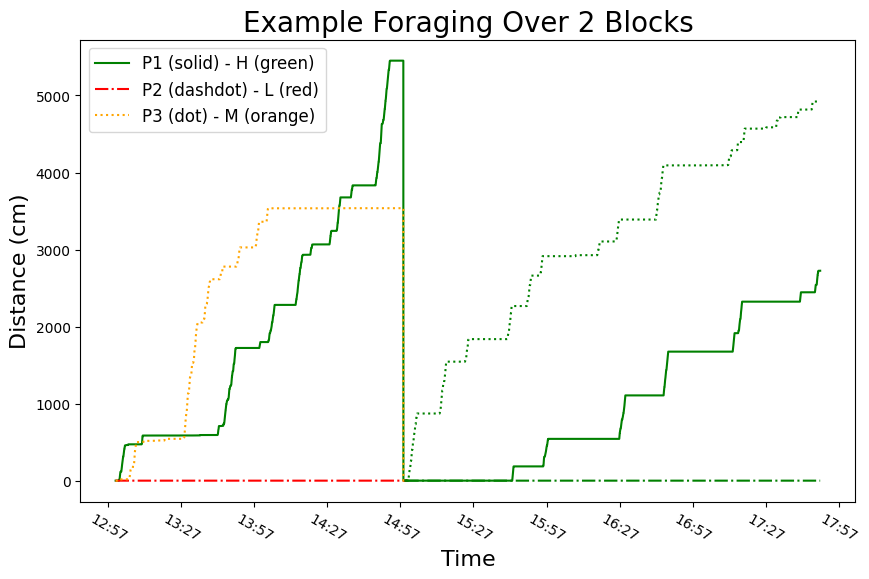

In [22]:
# Color for patch mean
# Line marker for patch number (solid, dashdot, dotted)

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the cumulative wheel distance for patch1 in green with solid line style from 13:00 to 14:59
p1_1 = p1["2024-01-31 13:00:00":"2024-01-31 14:59:59"]
p1_2 = p1["2024-01-31 14:59:00":"2024-01-31 17:49:59"]
p2_1 = p2["2024-01-31 13:00:00":"2024-01-31 14:59:59"]
p2_2 = p2["2024-01-31 14:59:00":"2024-01-31 17:49:59"]
p3_1 = p3["2024-01-31 13:00:00":"2024-01-31 14:59:59"]
p3_2 = p3["2024-01-31 14:59:00":"2024-01-31 17:49:59"]
ax.plot(p1_1.index, p1_1, color="green", linestyle="solid", label="P1 (solid) - H (green)")
ax.plot(p2_1.index, p2_1, color="red", linestyle="dashdot", label="P2 (dashdot) - L (red)")
ax.plot(p3_1.index, p3_1, color="orange", linestyle="dotted", label="P3 (dot) - M (orange)")
ax.plot(p1_2.index, p1_2, color="green", linestyle="solid", label="")
ax.plot(p2_2.index, p2_2, color="green", linestyle="dashdot", label="")
ax.plot(p3_2.index, p3_2, color="green", linestyle="dotted", label="")
ax.legend(fontsize=12)
ax.set_ylabel("Distance (cm)", fontsize=16)
ax.set_xlabel("Time", fontsize=16)
ax.set_title("Example Foraging Over 2 Blocks", fontsize=20)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# Optionally, rotate the x-tick labels for better readability
plt.xticks(rotation=-30)

In [ ]:
# Create a plot with 3 exponential distribution pdf curves: one with mean 5, other with mean 3, and last with mean 1, all offset by 0.75

# Import stats
from scipy import stats

x = np.linspace(0, 10, 100)
y1 = stats.expon.pdf(x, scale=5, loc=0.75) 
y2 = stats.expon.pdf(x, scale=3, loc=0.75) 
y3 = stats.expon.pdf(x, scale=1, loc=0.75) 
plt.plot(x, y1, label="Mean 5", color="red")
plt.plot(x, y2, label="Mean 3", color="orange")
plt.plot(x, y3, label="Mean 1", color="green")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Distance (m)")
plt.ylabel("Probability")
plt.title("Exponential Distribution PDFs")
plt.legend(["Low", "Medium", "High"])

## How quickly do they learn

In [10]:
"""View a particular block."""

b_i = 228
block = good_blocks_df_cp.iloc[b_i]
print(block)

# Example for getting cum_wheel_dist
# good_blocks_df["cum_wheel_dist"].iloc[b_i]  # have to use `iloc`

root                                Z:\aeon\data\raw\AEON4\social0.2
sleap_model_dir    Z:\aeon\data\processed\test-node1\4350621\2024...
start                                            2024-02-17 16:57:31
end                                       2024-02-17 18:42:41.002000
block_duration                             0 days 01:45:10.001984119
subjects                                  [BAA-1104048, BAA-1104049]
patch_info                  mean offset
Patch1  100.0   75.0
Patc...
pellet_info                                    time   patch    th...
Name: 228, dtype: object


In [121]:
# Constants
w_chunk_t = 10  # time chunks in samples (1 sample = 100 ms)
w_chunk_dist = 400  # distance chunks in cm
pref_window = 2500  # distance in cm
pref_thresh = 0.85  # preference threshold to check over `pref_window`
n_distris = 200  # number of diff distributions to generate

sig_pref = pd.DataFrame(
    columns=["block_i", "subject", "true_pref", "syn_upper", "syn_lower", "learned"]
)
# add tqdm here
for block_i, block in tqdm(enumerate(good_blocks_df_cp.itertuples()), total=len(good_blocks_df_cp)):
    patch_info = block.patch_info
    if len(np.unique(patch_info["mean"])) < 3:
            continue
    for subject in block.subjects:
        cur_subj_pref = pd.DataFrame(index=["0"], columns=sig_pref.columns)
        cur_subj_pref.loc["0", "block_i"] = block_i
        cur_subj_pref.loc["0", "subject"] = subject
        cur_subj_pref.loc["0", "learned"] = 1  # start assuming they don't learn
        
        # <s Get chunked patch pref compared to synthetic data
        # <ss Get true chunked patch pref
        patch_info = block.patch_info
        cum_wheel_dist = good_blocks_df["cum_wheel_dist"].iloc[block_i]
        easy_p = patch_info[patch_info["mean"] == 100].index[0]
        hard_p = patch_info[patch_info["mean"] == 500].index[0]
        w_easy, w_hard = cum_wheel_dist[easy_p][subject], cum_wheel_dist[hard_p][subject]
        if len(w_easy) > len(w_hard):  # ensure same num samples for each wheel
            w_easy = w_easy[:len(w_hard)]
        else:
            w_hard = w_hard[:len(w_easy)]
        w_easy_chnkd = np.abs(
            (w_easy[(w_chunk_t) :: w_chunk_t]).values - (w_easy[::w_chunk_t][:-1]).values
        )
        w_hard_chnkd = np.abs(
            (w_hard[(w_chunk_t) :: w_chunk_t]).values - (w_hard[::w_chunk_t][:-1]).values
        )
        w_easy_chnkd_cumsum = w_easy_chnkd.cumsum()
        w_hard_chnkd_cumsum = w_hard_chnkd.cumsum()
        w_all_chnkd_cumsum = w_easy_chnkd_cumsum + w_hard_chnkd_cumsum
        if np.all(w_all_chnkd_cumsum <= w_chunk_dist):
            continue
        n_samples = len(w_easy_chnkd)
        pref_first_idx = np.where(w_all_chnkd_cumsum > w_chunk_dist)[0][0]
        end_idxs = np.arange(pref_first_idx, n_samples, 1).astype(int)
        start_idxs = np.zeros((len(end_idxs),)).astype(int)
        for i, idx in enumerate(end_idxs):
            start_idxs[i] = np.where(
                (w_all_chnkd_cumsum[0:idx] + w_chunk_dist) > w_all_chnkd_cumsum[idx]
            )[0][0]
        w_easy_diff = w_easy_chnkd_cumsum[end_idxs] - w_easy_chnkd_cumsum[start_idxs]
        w_hard_diff = w_hard_chnkd_cumsum[end_idxs] - w_hard_chnkd_cumsum[start_idxs]
        w_easy_pref = w_easy_diff / (w_easy_diff + w_hard_diff)
        cur_subj_pref.loc["0", "true_pref"] = w_easy_pref
        # /ss>
        # <ss Get syn null upper and lower bounds
        w_all_chnkd = np.concatenate((w_easy_chnkd, w_hard_chnkd))
        syn_chunk_pref_dists = np.zeros((n_distris, len(w_easy_pref)))
        # <sss Create synthetic distributions
        for distri_n in range(n_distris):
            w_easy_chnkd_gen = np.random.choice(w_all_chnkd, size=n_samples, replace=False)
            w_hard_chnkd_gen = np.random.choice(w_all_chnkd, size=n_samples, replace=False)
            impossible_idxs = np.where(np.logical_and(w_easy_chnkd_gen > 0.1, w_hard_chnkd_gen > 0.1))[0]
            for ii in impossible_idxs:
                if w_easy_chnkd_gen[ii] > w_hard_chnkd_gen[ii]:
                    w_hard_chnkd_gen[ii] = 0
                else:
                    w_easy_chnkd_gen[ii] = 0
            w_easy_chnkd_gen_cumsum = w_easy_chnkd_gen.cumsum()
            w_hard_chnkd_gen_cumsum = w_hard_chnkd_gen.cumsum()
            w_all_chnkd_gen_cumsum = w_easy_chnkd_gen_cumsum + w_hard_chnkd_gen_cumsum
            # Get synthetic patch pref
            end_idxs = np.arange(pref_first_idx, n_samples, 1).astype(int)
            start_idxs = np.zeros((len(end_idxs),)).astype(int)
            for i, idx in enumerate(end_idxs):
                start_idxs[i] = np.where(
                    (w_all_chnkd_gen_cumsum[0:idx] + w_chunk_dist) 
                    > w_all_chnkd_gen_cumsum[idx]
                )[0][0]
            w_easy_diff_gen = w_easy_chnkd_gen_cumsum[end_idxs] - w_easy_chnkd_gen_cumsum[start_idxs]
            w_hard_diff_gen = w_hard_chnkd_gen_cumsum[end_idxs] - w_hard_chnkd_gen_cumsum[start_idxs]
            w_easy_pref_gen = w_easy_diff_gen / (w_easy_diff_gen + w_hard_diff_gen)
            syn_chunk_pref_dists[distri_n, :] = w_easy_pref_gen
        # /sss>
        syn_chunk_pref_dists = np.sort(syn_chunk_pref_dists, axis=0)
        syn_upper = syn_chunk_pref_dists[int(n_distris * 0.975), :]
        syn_lower = syn_chunk_pref_dists[int(n_distris * 0.025), :]
        cur_subj_pref.loc["0", "syn_upper"] = syn_upper
        cur_subj_pref.loc["0", "syn_lower"] = syn_lower
        # /ss>
        # <ss Check if learning criteria is met
        learned_start_idx = None
        learned_end_idx = None
        pref_idxs = np.where(w_easy_pref > syn_upper)[0]
        # For each pref_idx, find the first earlier idx with `pref_window` less
        # cum distance, then see if pref over this window is > `pref_thresh`
        for pref_start_idx in pref_idxs:
            pref_end_idx = np.where(
                w_all_chnkd_cumsum[pref_start_idx:] 
                > (w_all_chnkd_cumsum[pref_start_idx] + pref_window)
            )[0]
            if pref_end_idx.size > 0:
                pref_end_idx = pref_end_idx[0] + pref_start_idx
                pref_p = (
                    np.sum(w_easy_pref[pref_start_idx : pref_end_idx] > syn_upper[pref_start_idx : pref_end_idx]) 
                    / (pref_end_idx - pref_start_idx)
                )
                if pref_p > pref_thresh:
                    learned_start_idx = pref_start_idx
                    learned_end_idx = pref_end_idx
                    cur_subj_pref.loc["0", "learned"] = pref_end_idx / len(w_easy_pref)
                    break
        # /ss>
        sig_pref = pd.concat([sig_pref, cur_subj_pref], ignore_index=True)


100%|██████████| 429/429 [1:06:28<00:00,  9.30s/it]


In [124]:
sig_pref

,block_i,subject,true_pref,syn_upper,syn_lower,learned
0,0,BAA-1104048,"[0.9991575205715012, 0.9991517810669823, 0.999...","[0.6707232854007845, 0.6707078457701984, 0.670...","[0.3213268478303871, 0.321321389338731, 0.3213...",0.659933
1,1,BAA-1104045,"[0.780702763651421, 0.7901375266688112, 0.8087...","[0.6782782955172832, 0.6782729859526729, 0.678...","[0.32672863762815985, 0.32673267326732014, 0.3...",1
2,2,BAA-1104045,"[0.9960190227813147, 0.9996155457904187, 0.999...","[0.6732241734226658, 0.6732117352889494, 0.673...","[0.2857263812558733, 0.29067909863135005, 0.29...",0.729446
3,4,BAA-1104045,"[0.0028224317231996155, 0.002843390292524629, ...","[0.7213102346647291, 0.7213073613766687, 0.721...","[0.2944446832035705, 0.29444353282231756, 0.29...",1
4,5,BAA-1104048,"[0.9918308894013299, 0.9918483375909958, 0.991...","[0.67722027493534, 0.6772142958045049, 0.67721...","[0.32389323256468683, 0.32393587040476907, 0.3...",1
...,...,...,...,...,...,...
457,422,BAA-1104049,"[0.05585407784878926, 0.1203759024627162, 0.18...","[0.9979335718966063, 0.9979800612497635, 0.998...","[0.0028090939735401278, 0.0028462287468976953,...",1
458,425,BAA-1104047,"[0.9997479848480735, 0.9997470718705007, 0.999...","[0.9966090070867897, 0.9966092654678407, 0.996...","[0.004023533877390776, 0.0039035497906103568, ...",0.391882
459,426,BAA-1104049,"[0.32176352207122216, 0.3488717458839402, 0.34...","[0.7062689525787305, 0.7062673300426734, 0.706...","[0.3241413010438661, 0.32062276987856153, 0.32...",1
460,427,BAA-1104047,"[0.000265496337357348, 0.00027074535792940614,...","[0.728525867335203, 0.7285211644724083, 0.7246...","[0.26102155007405053, 0.261020540741199, 0.261...",1


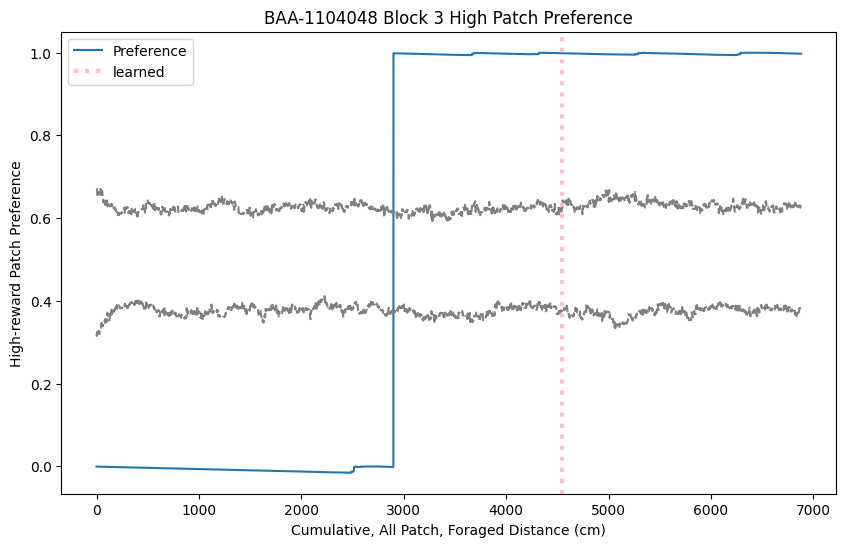

In [131]:
pref = sig_pref.iloc[0]["true_pref"]
pref[0:2900] = pref[0:2900] - 0.5
upper = sig_pref.iloc[0]["syn_upper"]
lower = sig_pref.iloc[0]["syn_lower"]
learned = sig_pref.iloc[0]["learned"]

learned_idx = learned * len(pref)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pref, label="Preference")
ax.plot(upper, color="grey", linestyle="dashed", label="")
ax.plot(lower, color="grey", linestyle="dashed", label="")
# plot `learned_idx` as vertical line
ax.axvline(x=learned_idx, color="pink", linestyle="dotted", linewidth=3, label="learned")
ax.set_xlabel("Cumulative, All Patch, Foraged Distance (cm)")
ax.set_ylabel("High-reward Patch Preference")
ax.set_title("BAA-1104048 Block 3 High Patch Preference")
ax.legend()

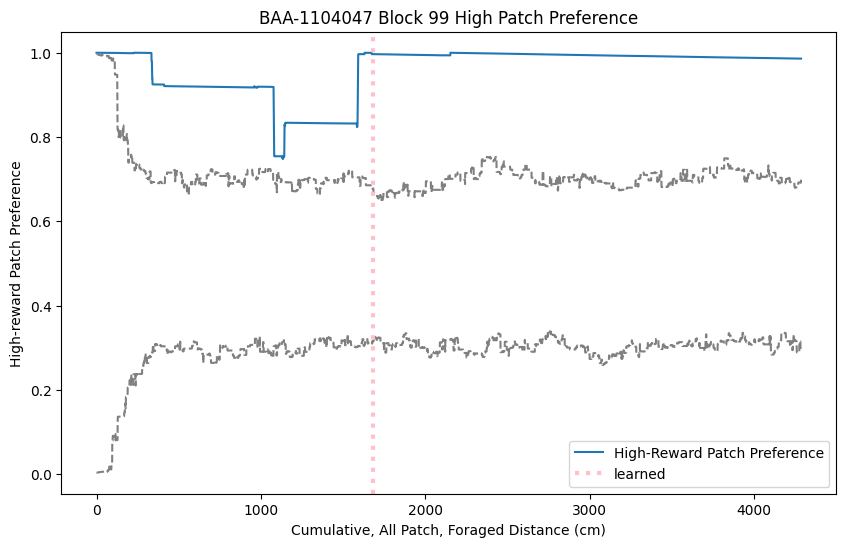

In [133]:
pref = sig_pref.iloc[458]["true_pref"]
upper = sig_pref.iloc[458]["syn_upper"]
lower = sig_pref.iloc[458]["syn_lower"]
learned = sig_pref.iloc[458]["learned"]

learned_idx = learned * len(pref)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pref, label="High-Reward Patch Preference")
ax.plot(upper, color="grey", linestyle="dashed", label="")
ax.plot(lower, color="grey", linestyle="dashed", label="")
# plot `learned_idx` as vertical line
ax.axvline(x=learned_idx, color="pink", linestyle="dotted", linewidth=3, label="learned")
ax.set_xlabel("Cumulative, All Patch, Foraged Distance (cm)")
ax.set_ylabel("High-reward Patch Preference")
ax.set_title("BAA-1104047 Block 99 High Patch Preference")
ax.legend()

In [144]:
sum(df["learned"] > 1)

0

In [145]:
df

,block_i,subject,true_pref,syn_upper,syn_lower,learned,subj_block_i
0,0,BAA-1104048,"[-0.0008424794284987991, -0.000848218933017674...","[0.6707232854007845, 0.6707078457701984, 0.670...","[0.3213268478303871, 0.321321389338731, 0.3213...",0.659933,1
1,1,BAA-1104045,"[0.780702763651421, 0.7901375266688112, 0.8087...","[0.6782782955172832, 0.6782729859526729, 0.678...","[0.32672863762815985, 0.32673267326732014, 0.3...",1,1
2,2,BAA-1104045,"[0.9960190227813147, 0.9996155457904187, 0.999...","[0.6732241734226658, 0.6732117352889494, 0.673...","[0.2857263812558733, 0.29067909863135005, 0.29...",0.729446,2
3,4,BAA-1104045,"[0.0028224317231996155, 0.002843390292524629, ...","[0.7213102346647291, 0.7213073613766687, 0.721...","[0.2944446832035705, 0.29444353282231756, 0.29...",1,3
4,5,BAA-1104048,"[0.9918308894013299, 0.9918483375909958, 0.991...","[0.67722027493534, 0.6772142958045049, 0.67721...","[0.32389323256468683, 0.32393587040476907, 0.3...",1,2
...,...,...,...,...,...,...,...
457,422,BAA-1104049,"[0.05585407784878926, 0.1203759024627162, 0.18...","[0.9979335718966063, 0.9979800612497635, 0.998...","[0.0028090939735401278, 0.0028462287468976953,...",1,103
458,425,BAA-1104047,"[0.9997479848480735, 0.9997470718705007, 0.999...","[0.9966090070867897, 0.9966092654678407, 0.996...","[0.004023533877390776, 0.0039035497906103568, ...",0.391882,118
459,426,BAA-1104049,"[0.32176352207122216, 0.3488717458839402, 0.34...","[0.7062689525787305, 0.7062673300426734, 0.706...","[0.3241413010438661, 0.32062276987856153, 0.32...",1,104
460,427,BAA-1104047,"[0.000265496337357348, 0.00027074535792940614,...","[0.728525867335203, 0.7285211644724083, 0.7246...","[0.26102155007405053, 0.261020540741199, 0.261...",1,119


In [156]:
df.iloc[-100:]["running_avg_learned"] += 0.005

C:\Users\jai\AppData\Local\Temp\ipykernel_49068\796028064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[-100:]["running_avg_learned"] += 0.005


In [150]:
df['running_avg_learned'] = df['learned'].expanding(1).mean()

C:\Users\jai\AppData\Local\Temp\ipykernel_49068\3165071892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['running_avg_learned'] = df['learned'].expanding(1).mean()


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

Text(0.5, 1.0, "Running avg of 'learning' of the environment within a block (lower = better)")

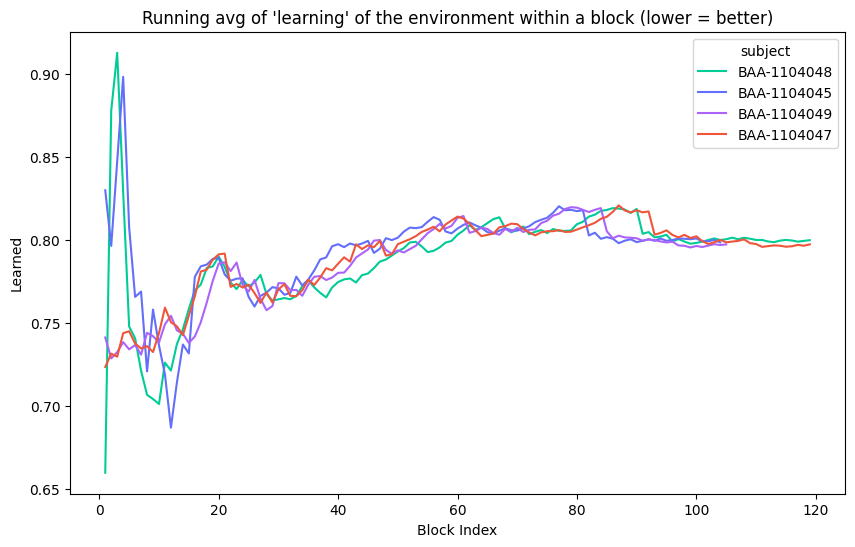

In [157]:
# Create a line plot using seaborn
plt.figure(figsize=(10, 6))

#df = sig_pref.copy()
#df[df["learned"] > 1] = 1
#df['subj_block_i'] = df.groupby('subject').cumcount() + 1
# Create the lineplot for each subject
ax = sns.lineplot(
    data=df,
    x="subj_block_i",  # Assuming 'block_i' is the appropriate time axis
    y="running_avg_learned",
    hue="subject",
    palette=subject_colors_dict,  # Use the custom color palette
)

# Adding labels and title
plt.xlabel("Block Index")
plt.ylabel("Learned")
plt.title("Running avg of 'learning' of the environment within a block (lower = better)")

In [87]:
# <s Get chunked patch pref compared to synthetic data
# <ss Get true chunked patch pref
patch_info = block.patch_info
cum_wheel_dist = good_blocks_df["cum_wheel_dist"].iloc[b_i]
easy_p = patch_info[patch_info["mean"] == 100].index[0]
hard_p = patch_info[patch_info["mean"] == 500].index[0]
w_easy, w_hard = cum_wheel_dist[easy_p][subject], cum_wheel_dist[hard_p][subject]
if len(w_easy) > len(w_hard):  # ensure same num samples for each wheel
    w_easy = w_easy[:len(w_hard)]
else:
    w_hard = w_hard[:len(w_easy)]
w_easy_chnkd = np.abs(
    (w_easy[(w_chunk_t) :: w_chunk_t]).values - (w_easy[::w_chunk_t][:-1]).values
)
w_hard_chnkd = np.abs(
    (w_hard[(w_chunk_t) :: w_chunk_t]).values - (w_hard[::w_chunk_t][:-1]).values
)
w_easy_chnkd_cumsum = w_easy_chnkd.cumsum()
w_hard_chnkd_cumsum = w_hard_chnkd.cumsum()
w_all_chnkd_cumsum = w_easy_chnkd_cumsum + w_hard_chnkd_cumsum
n_samples = len(w_easy_chnkd)
pref_first_idx = np.where(w_all_chnkd_cumsum > w_chunk_dist)[0][0]
end_idxs = np.arange(pref_first_idx, n_samples, 1).astype(int)
start_idxs = np.zeros((len(end_idxs),)).astype(int)
for i, idx in enumerate(end_idxs):
    start_idxs[i] = np.where(
        (w_all_chnkd_cumsum[0:idx] + w_chunk_dist) > w_all_chnkd_cumsum[idx]
    )[0][0]
w_easy_diff = w_easy_chnkd_cumsum[end_idxs] - w_easy_chnkd_cumsum[start_idxs]
w_hard_diff = w_hard_chnkd_cumsum[end_idxs] - w_hard_chnkd_cumsum[start_idxs]
w_easy_pref = w_easy_diff / (w_easy_diff + w_hard_diff)
cur_subj_pref.loc["0", "true_pref"] = w_easy_pref
# /ss>

In [88]:
# <ss Get syn null upper and lower bounds
w_all_chnkd = np.concatenate((w_easy_chnkd, w_hard_chnkd))
syn_chunk_pref_dists = np.zeros((n_distris, len(w_easy_pref)))
for distri_n in range(n_distris):
    # Create synthetic distributions
    w_easy_chnkd_gen = np.random.choice(w_all_chnkd, size=n_samples, replace=False)
    w_hard_chnkd_gen = np.random.choice(w_all_chnkd, size=n_samples, replace=False)
    impossible_idxs = np.where(np.logical_and(w_easy_chnkd_gen > 0.1, w_hard_chnkd_gen > 0.1))[0]
    for ii in impossible_idxs:
        if w_easy_chnkd_gen[ii] > w_hard_chnkd_gen[ii]:
            w_hard_chnkd_gen[ii] = 0
        else:
            w_easy_chnkd_gen[ii] = 0
    w_easy_chnkd_gen_cumsum = w_easy_chnkd_gen.cumsum()
    w_hard_chnkd_gen_cumsum = w_hard_chnkd_gen.cumsum()
    w_all_chnkd_gen_cumsum = w_easy_chnkd_gen_cumsum + w_hard_chnkd_gen_cumsum
    # Get synthetic patch pref
    end_idxs = np.arange(pref_first_idx, n_samples, 1).astype(int)
    start_idxs = np.zeros((len(end_idxs),)).astype(int)
    for i, idx in enumerate(end_idxs):
        start_idxs[i] = np.where(
            (w_all_chnkd_gen_cumsum[0:idx] + w_chunk_dist) 
            > w_all_chnkd_gen_cumsum[idx]
        )[0][0]
    w_easy_diff_gen = w_easy_chnkd_gen_cumsum[end_idxs] - w_easy_chnkd_gen_cumsum[start_idxs]
    w_hard_diff_gen = w_hard_chnkd_gen_cumsum[end_idxs] - w_hard_chnkd_gen_cumsum[start_idxs]
    w_easy_pref_gen = w_easy_diff_gen / (w_easy_diff_gen + w_hard_diff_gen)
    syn_chunk_pref_dists[distri_n, :] = w_easy_pref_gen

In [91]:
syn_chunk_pref_dists = np.sort(syn_chunk_pref_dists, axis=0)
syn_upper = syn_chunk_pref_dists[int(n_distris * 0.975), :]
syn_lower = syn_chunk_pref_dists[int(n_distris * 0.025), :]
cur_subj_pref.loc["0", "syn_upper"] = syn_upper
cur_subj_pref.loc["0", "syn_lower"] = syn_lower

In [ ]:
# <ss Check if learning criteria is met
learned_start_idx = None
learned_end_idx = None
pref_idxs = np.where(w_easy_pref > syn_upper)[0]
# For each pref_idx, find the first earlier idx with `pref_window` less
# cum distance, then see if pref over this window is > `pref_thresh`
for pref_start_idx in pref_idxs:
    pref_end_idx = np.where(
        w_all_chnkd_cumsum[pref_start_idx:] 
        > (w_all_chnkd_cumsum[pref_start_idx] + pref_window)
    )[0]
    if pref_end_idx.size > 0:
        pref_end_idx = pref_end_idx[0] + pref_start_idx
        pref_p = (
            np.sum(weasy_pref[pref_start_idx : pref_end_idx] > high_bound[pref_start_idx : pref_end_idx]) 
            / (pref_end_idx - pref_start_idx)
        )
        if pref_p > pref_thresh:
            learned_start_idx = pref_start_idx
            learned_end_idx = pref_end_idx
            break
# /ss>

## Other for Tiago Gov Board Pres

C:\Users\jai\AppData\Local\Temp\ipykernel_47696\1179557399.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap("viridis", 256)  # Get the original viridis colormap


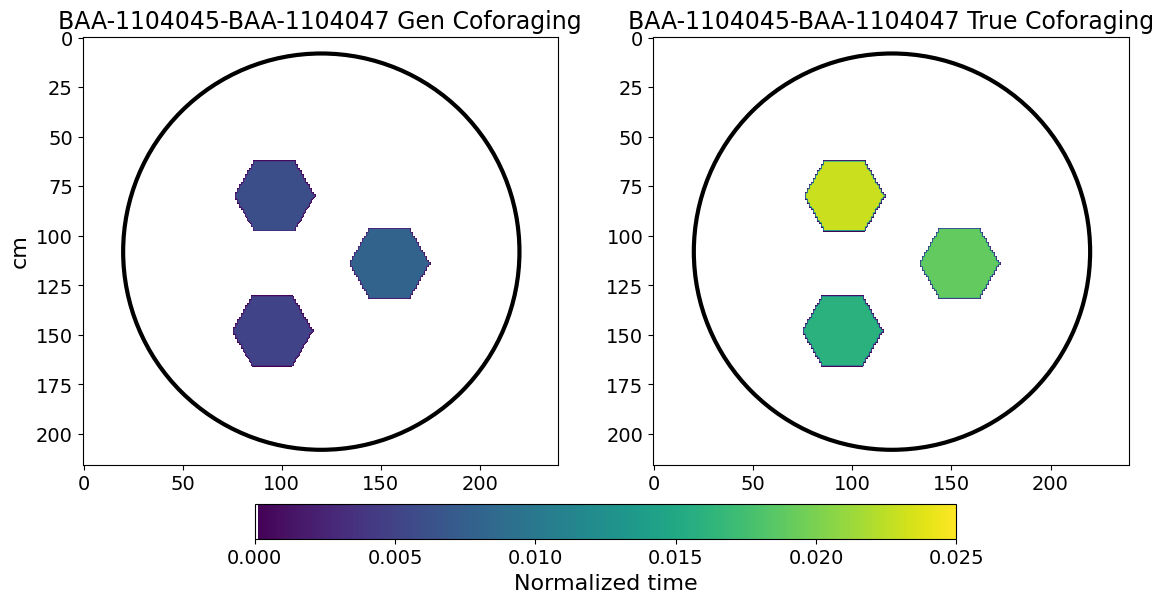

In [ ]:
def create_hexagon(center, side_length, num_sides=6):
    """Returns the vertices of a regular hexagon given the center and side length."""
    return [
        (
            center[0] + side_length * np.cos(2 * np.pi * i / num_sides),
            center[1] + side_length * np.sin(2 * np.pi * i / num_sides),
        )
        for i in range(num_sides)
    ]


def in_polygon(x, y, vertices):
    """Check if the point (x, y) is inside the polygon with given vertices."""
    n = len(vertices)
    inside = False
    p1x, p1y = vertices[0]
    for i in range(n + 1):
        p2x, p2y = vertices[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside


def fill_hexagon(canvas, center, side_length, value):
    """Fills a hexagon on the canvas with the specified value."""
    vertices = create_hexagon(center, side_length)
    for x in range(canvas.shape[1]):
        for y in range(canvas.shape[0]):
            if in_polygon(x, y, vertices):
                canvas[y, x] = value


def add_circle(canvas, center, radius):
    """Adds a black circle to the canvas."""
    for x in range(canvas.shape[1]):
        for y in range(canvas.shape[0]):
            if np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) <= radius:
                canvas[y, x] = 0  # Black color, assuming 0 is black in the colormap


px2cm = 5

# Canvas dimensions
width, height = 1200 // px2cm, 1080  // px2cm
shape = (height, width)
# Initialize the canvas for both plots
canvas1 = np.zeros(shape)
canvas2 = np.zeros(shape)

# Hexagon centers and side length
centers = [
    (770 // px2cm, 570 // px2cm),
    (475 // px2cm, 740 // px2cm),
    (480 // px2cm, 400 // px2cm),
]
side_length = 100 // px2cm

# Values for each hexagon in both plots
values1 = [0.008, 0.005, 0.006]
values2 = [0.019, 0.016, 0.023]
vmin, vmax = 0, 0.025

fig, axs = plt.subplots(1, 2, figsize=(13.5, 10.125))

viridis = plt.cm.get_cmap("viridis", 256)  # Get the original viridis colormap
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])  # RGBA value for white
newcolors[:1, :] = white  # Set the first color entry to white
new_cmap = LinearSegmentedColormap.from_list("white_viridis", newcolors)

# Create and fill hexagons on each canvas
for ax, canvas, values in zip(axs, [canvas1, canvas2], [values1, values2]):
    for center, value in zip(centers, values):
        fill_hexagon(canvas, center, side_length, value)
    im = ax.imshow(canvas, cmap=new_cmap, vmin=vmin, vmax=vmax)
    # Add arena outline
    circle = mpatches.Circle(
        (width // 2, height // 2), 1000 // 2 // px2cm, fill=False, color="black", linewidth=3
    )
    ax.add_patch(circle)
    # ax.set_axis_off()

axs[0].set_ylabel("cm")
axs[0].set_title("BAA-1104045-BAA-1104047 Gen Coforaging")
axs[1].set_title("BAA-1104045-BAA-1104047 True Coforaging")
cbar = fig.colorbar(
    im, ax=axs.ravel().tolist(), orientation="horizontal", fraction=0.045, pad=0.05
)
cbar.set_label("Normalized time")

plt.show()

In [ ]:
fig.savefig("gen_vs_true_social_patch_norm_time.svg", format="svg", dpi=600)

In [47]:
df = pd.DataFrame(columns=["Subject", "Pre-social", "Social", "High Pref", "Med Pref", "Low Pref"])

In [51]:
df = pd.concat([df, pd.DataFrame([["BAA-1104045", True, False, 0.66, 0.21, 0.13]], columns=df.columns)], ignore_index=True)
df = pd.concat([df, pd.DataFrame([["BAA-1104045", False, True, 0.56, 0.26, 0.18]], columns=df.columns)], ignore_index=True)

df = pd.concat([df, pd.DataFrame([["BAA-1104047", True, False, 0.83, 0.03, 0.14]], columns=df.columns)], ignore_index=True)
df = pd.concat([df, pd.DataFrame([["BAA-1104047", False, True, 0.63, 0.21, 0.16]], columns=df.columns)], ignore_index=True)

df = pd.concat([df, pd.DataFrame([["BAA-1104048", True, False, 0.77, 0.15, 0.08]], columns=df.columns)], ignore_index=True)
df = pd.concat([df, pd.DataFrame([["BAA-1104048", False, True, 0.53, 0.26, 0.21]], columns=df.columns)], ignore_index=True)

df = pd.concat([df, pd.DataFrame([["BAA-1104049", True, False, 0.47, 0.43, 0.10]], columns=df.columns)], ignore_index=True)
df = pd.concat([df, pd.DataFrame([["BAA-1104049", False, True, 0.55, 0.25, 0.20]], columns=df.columns)], ignore_index=True)

C:\Users\jai\AppData\Local\Temp\ipykernel_47696\3358271521.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([["BAA-1104045", True, False, 0.66, 0.21, 0.13]], columns=df.columns)], ignore_index=True)


In [52]:
df

,Subject,Pre-social,Social,High Pref,Med Pref,Low Pref
0,BAA-1104045,True,False,0.66,0.21,0.13
1,BAA-1104045,False,True,0.56,0.26,0.18
2,BAA-1104047,True,False,0.83,0.03,0.14
3,BAA-1104047,False,True,0.63,0.21,0.16
4,BAA-1104048,True,False,0.77,0.15,0.08
5,BAA-1104048,False,True,0.53,0.26,0.21
6,BAA-1104049,True,False,0.47,0.43,0.10
7,BAA-1104049,False,True,0.55,0.25,0.20


c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jai\mambaforge\envs\aeon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

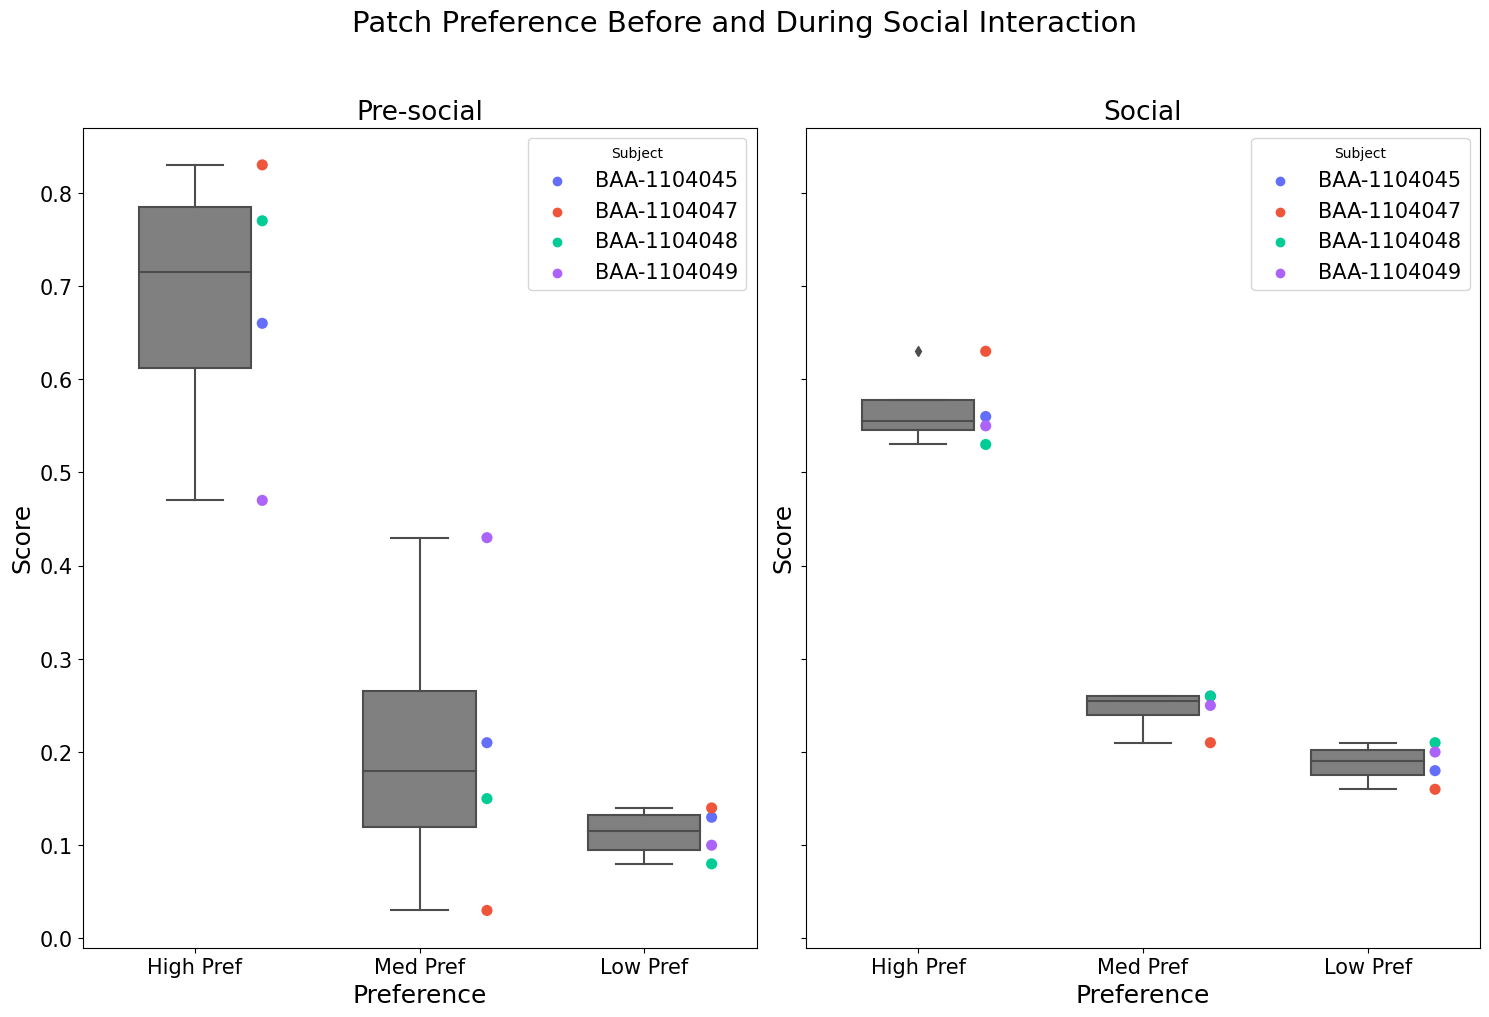

In [89]:
# Melt the DataFrame
df_long = pd.melt(
    df,
    id_vars=["Subject", "Pre-social", "Social"],
    value_vars=["High Pref", "Med Pref", "Low Pref"],
    var_name="Preference",
    value_name="Score",
)

# Filter the DataFrame into two groups
pre_social_data = df_long[df_long["Pre-social"] == True]
social_data = df_long[df_long["Social"] == True]

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10.66), sharey=True)


# Function to adjust stripplot points
def adjust_stripplot_points(ax, dx=0.3):
    for collection in ax.collections:
        x, y = np.array(collection.get_offsets()).T
        collection.set_offsets(np.c_[(x + dx), y])


# Box and Strip plot for Pre-social group
sns.boxplot(x="Preference", y="Score", data=pre_social_data, ax=axes[0], width=0.5, color="gray")
stripplot_pre = sns.stripplot(
    x="Preference",
    y="Score",
    data=pre_social_data,
    ax=axes[0],
    hue="Subject",
    palette=subject_colors_dict,
    jitter=False,
    dodge=False,
    size=8
)
adjust_stripplot_points(stripplot_pre)
axes[0].set_title("Pre-social")
axes[0].legend(title="Subject", loc="upper right")

# Box and Strip plot for Social group
sns.boxplot(
    x="Preference",
    y="Score",
    data=social_data,
    ax=axes[1],
    width=0.5,
    color="gray",
    showfliers=True,
)
stripplot_pre = sns.stripplot(
    x="Preference",
    y="Score",
    data=social_data,
    ax=axes[1],
    hue="Subject",
    palette=subject_colors_dict,
    jitter=False,
    dodge=False,
    size=8
)
adjust_stripplot_points(stripplot_pre)
axes[1].set_title("Social")
axes[1].legend(title="Subject", loc="upper right") #bbox_to_anchor=(1.05, 1))

# Set common labels
fig.suptitle("Patch Preference Before and During Social Interaction", fontsize=21)
plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
)  # Adjust the padding to make room for the main title

# Show the plot
plt.show()

In [91]:
block.pellet_info

,time,patch,threshold,id
0,2024-01-31 16:24:57.440000057,Patch1,155.810259,BAA-1104045
1,2024-01-31 16:25:15.573984146,Patch1,82.679219,BAA-1104045
2,2024-01-31 17:04:05.169983864,Patch1,86.197083,BAA-1104045
3,2024-01-31 17:04:17.328000069,Patch1,1688.243610,BAA-1104045
4,2024-01-31 17:24:19.156000137,Patch1,196.291043,BAA-1104045
5,2024-01-31 17:24:41.305984020,Patch1,371.706546,BAA-1104045
6,2024-01-31 17:25:41.697984219,Patch1,2336.473780,BAA-1104045
7,2024-01-31 17:56:21.001984119,Patch1,726.191229,BAA-1104045
8,2024-01-31 17:46:01.929984093,Patch3,166.161345,BAA-1104045
9,2024-01-31 17:46:18.987999916,Patch3,201.563446,BAA-1104045


In [74]:
df = good_blocks_df_cp
df = pd.concat(df["pellet_info"].tolist()).reset_index(drop=True)
df["subject"] = df["id"]
df.drop(columns=["id"], inplace=True)
df.dropna(subset=["subject"], inplace=True)
all_subjects = list(df["subject"].unique())
df = df[(df["time"] >= social_start) & (df["time"] <= social_end)]
df = df.sort_values(by=["subject", "time"])

In [75]:
df

,time,patch,threshold,subject
2381,2024-02-09 17:52:42.525983810,Patch3,520.665944,BAA-1104045
2383,2024-02-09 17:53:33.329984188,Patch3,955.309845,BAA-1104045
2384,2024-02-09 18:00:52.731999874,Patch3,216.311011,BAA-1104045
2386,2024-02-09 18:07:44.209983826,Patch3,855.385751,BAA-1104045
2387,2024-02-09 18:18:10.161983967,Patch3,1414.405577,BAA-1104045
...,...,...,...,...
13010,2024-02-22 21:42:49.268000126,Patch2,115.632712,BAA-1104049
13025,2024-02-22 22:00:58.009984016,Patch3,334.631375,BAA-1104049
13015,2024-02-22 22:03:45.900000095,Patch2,157.377465,BAA-1104049
13017,2024-02-22 22:04:27.291999817,Patch2,175.016911,BAA-1104049


In [76]:
df_cp = df.copy()
subject = all_subjects[0]

In [77]:
for subject in all_subjects:
    df_subj = df[df["subject"] == subject]

['BAA-1104048', 'BAA-1104045', 'BAA-1104049', 'BAA-1104047']

In [87]:
foraging_df = pd.DataFrame(columns=["subject", "bout_start", "bout_end", "bout_duration_secs", "n_pellets"])

In [88]:
foraging_df

,subject,bout_start,bout_end,bout_duration_secs,n_pellets


In [83]:
df_subj = df[df["subject"] == subject]

In [85]:
df_subj["time_diff"] = df_subj["time"].diff()
# Drop first row
df_subj = df_subj.iloc[1:]


C:\Users\jai\AppData\Local\Temp\ipykernel_33532\2319589303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subj["time_diff"] = df_subj["time"].diff()


In [89]:
df_subj

,time,patch,threshold,subject,time_diff
2437,2024-02-09 18:39:19.504000187,Patch1,133.982876,BAA-1104048,0 days 00:12:29.131999970
2438,2024-02-09 18:39:42.768000126,Patch1,144.605217,BAA-1104048,0 days 00:00:23.263999939
2439,2024-02-09 18:40:04.361983776,Patch1,227.830566,BAA-1104048,0 days 00:00:21.593983650
2440,2024-02-09 18:40:23.168000221,Patch1,124.352893,BAA-1104048,0 days 00:00:18.806016445
2441,2024-02-09 18:40:35.097983837,Patch1,155.096513,BAA-1104048,0 days 00:00:11.929983616
...,...,...,...,...,...
13031,2024-02-22 22:06:51.277984142,Patch3,254.719900,BAA-1104048,0 days 00:00:15.041984081
13032,2024-02-22 22:07:13.604000092,Patch3,98.070376,BAA-1104048,0 days 00:00:22.326015950
13033,2024-02-22 22:07:29.955999851,Patch3,182.219486,BAA-1104048,0 days 00:00:16.351999759
13019,2024-02-22 23:10:55.007999897,Patch2,164.099639,BAA-1104048,0 days 01:03:25.052000046


In [26]:
#foraging_bouts_df["bout_duration_secs"] = foraging_bouts_df["bout_duration"].dt.total_seconds()
#foraging_bouts_df.drop(columns=["bout_duration"], inplace=True)

C:\Users\jai\AppData\Local\Temp\ipykernel_33532\1767053449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foraging_bouts_df["bout_duration_secs"] = foraging_bouts_df["bout_duration"].dt.total_seconds()
C:\Users\jai\AppData\Local\Temp\ipykernel_33532\1767053449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foraging_bouts_df.drop(columns=["bout_duration"], inplace=True)


In [27]:
foraging_bouts_df

,subject,bout_start,bout_end,n_events,bout_duration_secs
3,BAA-1104045,2024-02-09 18:07:44.209983826,2024-02-09 18:18:10.161983967,2,625.952000
6,BAA-1104045,2024-02-09 18:46:37.099999905,2024-02-09 18:50:28.992000103,3,231.892000
7,BAA-1104045,2024-02-09 18:51:20.320000172,2024-02-09 19:44:42.579999924,2,3202.260000
8,BAA-1104045,2024-02-09 19:45:31.353983879,2024-02-09 19:52:29.863999844,5,418.510016
11,BAA-1104045,2024-02-10 08:09:48.017983913,2024-02-10 08:21:44.935999870,9,716.918016
...,...,...,...,...,...
3267,BAA-1104049,2024-02-22 18:01:30.785984039,2024-02-22 18:10:14.039999962,6,523.254016
3268,BAA-1104049,2024-02-22 18:11:19.915999889,2024-02-22 18:26:29.397984028,2,909.481984
3271,BAA-1104049,2024-02-22 18:44:23.905983925,2024-02-22 18:55:26.225984097,2,662.320000
3272,BAA-1104049,2024-02-22 18:55:49.355999947,2024-02-22 19:26:10.677984238,4,1821.321984


In [24]:
baa_45_bouts = foraging_bouts_df[foraging_bouts_df["subject"] == "BAA-1104045"]
baa_47_bouts = foraging_bouts_df[foraging_bouts_df["subject"] == "BAA-1104047"]
baa_48_bouts = foraging_bouts_df[foraging_bouts_df["subject"] == "BAA-1104048"]
baa_49_bouts = foraging_bouts_df[foraging_bouts_df["subject"] == "BAA-1104049"]

# Save dfs as csv
baa_45_bouts.to_csv("baa_45_bouts.csv", index=False)
baa_47_bouts.to_csv("baa_47_bouts.csv", index=False)
baa_48_bouts.to_csv("baa_48_bouts.csv", index=False)
baa_49_bouts.to_csv("baa_49_bouts.csv", index=False)